<a href="https://colab.research.google.com/github/Nohalyan/Nohalyan/blob/main/Notebook_Molpal_AI4chem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Project AI for chemistry: Leveraging Active Learning with uncertainty quantification by Investigation of Molpal Exploration


Molpal (Molecular Pool-based Active Learning) is a software created by the coleygroup for the accelerated discovery of compounds in high-throughput virtual screening environments. Using a modified version of Molpal, the objective is to find a good way to leverage active learning and uncertainty quantification to minimize the number of total molecules acquired by the algorithm, while recovering a good percentage of the top X% of the candidates depending on the dataset.

##1.1 Dependencies and pip installations

In [ ]:
!pip install torch torchvision torchaudio
!pip install configargparse
!pip install h5py
!pip install numpy
!pip install -U ray[default]>=1.11
!pip install ray
!pip install rdkit
!pip install pytorch-lightning
!pip install scikit-learn
!pip install tensorflow
!pip install tensorflow-addons
!pip install tqdm
!pip install umap-learn

In [ ]:
import pandas as pd

In [ ]:
!apt-get install git

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git is already the newest version (1:2.34.1-1ubuntu1.10).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


In [ ]:
!git clone https://github.com/Nohalyan/molpal.git
%ls

Cloning into 'molpal'...
remote: Enumerating objects: 4209, done.
remote: Counting objects: 100% (292/292), done.
remote: Compressing objects: 100% (163/163), done.
remote: Total 4209 (delta 155), reused 201 (delta 128), pack-reused 3917
Receiving objects: 100% (4209/4209), 118.66 MiB | 62.89 MiB/s, done.
Resolving deltas: 100% (2780/2780), done.
'=1.11'   molpal/   sample_data/


## 1.2 Installing molpal packages

In [ ]:
from molpal.acquirer import Acquirer
from molpal.featurizer import Featurizer
from molpal.models import Model
from molpal.objectives import Objective
from molpal.pools import pool
from molpal.exceptions import IncompatibilityError, InvalidExplorationError
from molpal.explorer import Explorer

In [ ]:
!pip show molpal

## 1.3 Data Preparation - Virtual Library Preparation

In [ ]:
%cd /content/molpal/data
%ls

In [ ]:

df_10k = pd.read_csv('Enamine10k_scores.csv.gz')
df_10k.head()

Let's create csv with only SMILES for Enamine10k and 50k

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
%cd /content/molpal/data/
%ls

/content/molpal/data
Enamine10k_scores.csv.gz  EnamineHTS_pair_umap.npy
Enamine50k_scores.csv.gz  EnamineHTS_scores.csv.gz


In [ ]:
df10k = pd.read_csv("Enamine10k_scores.csv.gz")

df10k.drop(columns=["score"], inplace=True)

df10k.to_csv("Enamine10k_smiles.csv.gz", index=False, columns=["smiles"])

df10k.head()

,smiles
0,O=C(CCC1CCOC1)N1C[C@H]2CCC[C@@]2(c2nc(-c3ccccc...
1,O=C(NCCc1cccc(-c2ccccc2)c1)[C@@H]1CCCCN1
2,Cc1ccc(-c2noc(CN3CC=C(c4c[nH]c5ccccc45)CC3)n2)cc1
3,O=C(Nc1ccc2c(c1)COC2)[C@H]1CCO[C@@H]1c1ccnn1Cc...
4,Cc1nnc([C@]23CCC[C@H]2CN(C(=O)c2cc4[nH]cnc4cc2...


## Let's visualise the score distribution

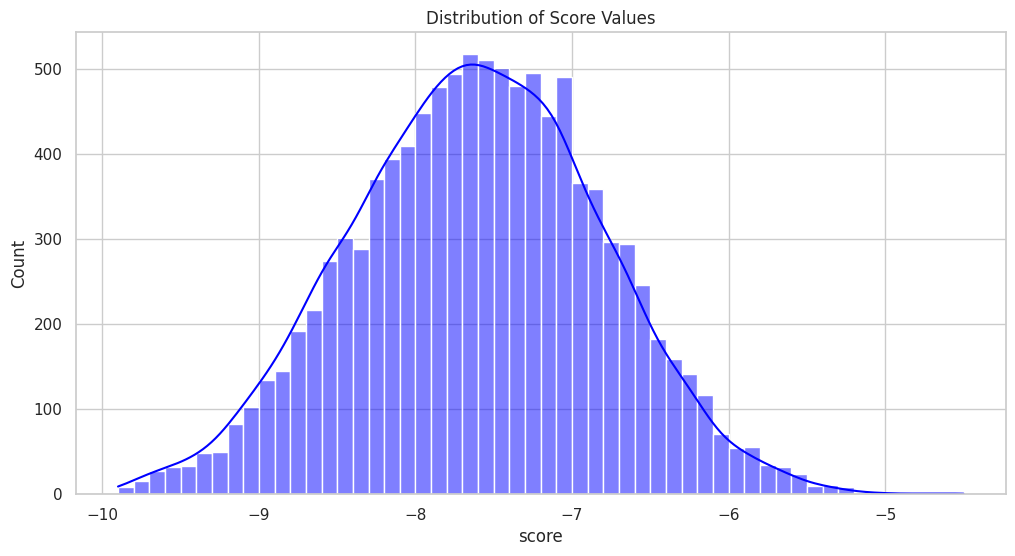

In [ ]:
df = pd.read_csv('/content/molpal/data/Enamine10k_scores.csv.gz')

sns.set(style="whitegrid")

plt.figure(figsize=(12, 6))
sns.histplot(df['score'], kde=True, color='blue', binwidth=0.1)
plt.title('Distribution of Score Values')
plt.xlabel('score')
plt.ylabel('Count')
plt.show()

## From there, the selection will be focused on the top 1% of the best performant molecules

In [ ]:
df = pd.read_csv('/content/molpal/data/Enamine10k_scores.csv.gz')

df_sorted = df.sort_values(by='score', ascending=False)

percentile_index = int(len(df_sorted) * 0.01)

top_1per_df = df_sorted.iloc[:percentile_index]

top_1per_df.reset_index(drop=True, inplace=True)

top_1per_df.to_csv('/content/molpal/data/top_1per_scores.csv', index=True)

top_1per_df

And if we want to use Enamine50k:

In [ ]:
df50k = pd.read_csv("Enamine50k_scores.csv.gz")

df50k.drop(columns=["score"], inplace=True)

df50k.to_csv("Enamine50k_smiles.csv.gz", index=False, columns=["smiles"])

df50k.head()

In [ ]:
df = pd.read_csv('/content/molpal/data/Enamine50k_scores.csv.gz')

df_sorted = df.sort_values(by='score', ascending=False)

percentile_index = int(len(df_sorted) * 0.01)

top_1per_df = df_sorted.iloc[:percentile_index]

top_1per_df.reset_index(drop=True, inplace=True)

top_1per_df.to_csv('/content/molpal/data/top_1per_scores.csv', index=True)

top_1per_df

## 1.4 Library Featurization - Fingerprint generation

## Let's create a folder output

In [ ]:
%cd /content/molpal

!mkdir folder_output

/content/molpal


In [ ]:
%cd folder_output

/content/molpal/folder_output


## Let's generate of fingerprints

In [ ]:
!python /content/molpal/scripts/fingerprints.py -o fps_file --library /content/molpal/data/Enamine10k_smiles.csv.gz  \ # Change the path to /content/molpal/data/Enamine50k_smiles.csv.gz to use Enamine50k
--fingerprint pair --length 2048 --radius 2

## Verification that the fps_file create exists

In [ ]:
import os

output_file = "fps_file.h5"
if os.path.exists(output_file):
    print("The file exists.")
else:
    print("The file does not exist.")

The file exists.


#2. MolPAL



## 2.1 Running MolPAL

## Make sure you are in folder_output

In [ ]:
%pwd

'/content/molpal/folder_output'

## Let's define a function to merge all the data generated from the run

In [2]:
def process_and_merge_csvs(csv_score, csv_ucb, csv_std, output_filename):

    df1 = pd.read_csv(csv_score)

    df2 = pd.read_csv(csv_ucb, header=None)
    df2_transposed = df2.T

    df2_transposed.reset_index(drop=True, inplace=True)

    ucb_values = df2_transposed.iloc[:, -1]

    df3 = pd.read_csv(csv_std, header=None)
    df3_transposed = df3.T

    df3_transposed.reset_index(drop=True, inplace=True)

    std_values = df3_transposed.iloc[:, -1]


    df_score_UCB = pd.merge(df1, ucb_values, left_index=True, right_index=True)
    df_score_UCB_dev = pd.merge(df_score_UCB, std_values, left_index=True, right_index=True)


    new_column_names = list(df_score_UCB_dev.columns)
    new_column_names[-2] = 'UCB'
    new_column_names[-1] = 'Std dev'

    df_score_UCB_dev.columns = new_column_names

    df_score_UCB_dev.to_csv(output_filename, index=False)

    print(f"Output saved to {output_filename}")



def selection_fct(csv_all, csv_allselected, output_csv):

    import pandas as pd

    df1 = pd.read_csv(f"{csv_all}")

    df2 = pd.read_csv(f"{csv_allselected}")

    matches = df2[['smiles']].merge(df1.reset_index(), on='smiles', how='inner')

    matched_rows = df1.loc[matches['index']]

    new_df = matched_rows.copy()

    new_df1 = new_df.sort_values(by = 'score', ascending = False)

    return new_df1.to_csv(output_csv, index=False)


## Let's define a function to run the software to make better use of the files generated by the software

In [ ]:
def Molpal_run(model, confid, metrics, init, batches, max_iter, dataset, top_x_perc, k, BETA):

    """
    Runs the molpal tool with specified parameters, processes the results, and evaluates the fraction of top X% molecules found.

    Parameters:
    - model (str): The model to be used by molpal.
    - confid (str): The confidence method to be used.
    - metrics (str): The metric for evaluation.
    - init (int): Initial size of the dataset.
    - batches (int): Batch size for iterations.
    - max_iter (int): Maximum number of iterations.
    - dataset (int): Dataset identifier used to specify the dataset file.
    - top_x_perc (float): The top X percentage of molecules to consider.
    - k (int): Number of top samples to select.
    - BETA (float): Beta parameter for model configuration.

    Functionality:
    1. Runs the molpal tool with the specified parameters, generating intermediate and final output files.
    2. Moves and renames the final output file.
    3. Reads the dataset file and selects the top X% of molecules based on their scores.
    4. Saves the selected top X% molecules to a new file.
    5. Reads the final output file from molpal and finds common molecules with the top X% list.
    6. Prints the fraction of top X% molecules found in the final output.
    7. Processes and merges CSV files.
    8. Performs selection using the specified function.

    Outputs:
    - Prints the fraction of top X% molecules found.
    - Moves and renames output files.
    - Calls additional functions to process and select data.
    """

    !molpal run --write-intermediate --write-final --retrain-from-scratch --library /content/molpal/data/Enamine10k_scores.csv.gz -o lookup --objective-config /content/molpal/examples/objective/Enamine10k_lookup.ini \
        --model {model} --conf-method {confid} --metric {metrics} --init-size {init} \
        --batch-size {batches} --max-iters {max_iter} --fps /content/molpal/folder_output/fps_file.h5 \
        --output-dir run_output -k {k} --beta {BETA}

    output_filename_csv = f"/content/molpal/folder_output/run_output/all_explored_final_{model}_{metrics}_{init}_{batches}_{max_iter}_beta_{BETA}.csv"
    !mv /content/molpal/folder_output/run_output/all_explored_final.csv {output_filename_csv}

    output_folder_name = f"/content/molpal/folder_output/run_output_{model}_{metrics}_{init}_{batches}_{max_iter}_beta_{BETA}"
    !mv /content/molpal/folder_output/run_output {output_folder_name}

    file_path = f'/content/molpal/data/Enamine{dataset}k_scores.csv.gz'
    df = pd.read_csv(file_path)

    df_sorted = df.sort_values(by='score', ascending=True)

    percentile_index = int(len(df_sorted)* top_x_perc)

    top_x_smiles = df_sorted[['smiles', 'score']].iloc[:percentile_index]

    output_file_path = f'/content/molpal/data/Top_{top_x_perc}_Enamine10k_scores.csv'
    top_x_smiles.to_csv(output_file_path, index=False)

    df_found = pd.read_csv(f"/content/molpal/folder_output/run_output_{model}_{metrics}_{init}_{batches}_{max_iter}_beta_{BETA}/all_explored_final_{model}_{metrics}_{init}_{batches}_{max_iter}_beta_{BETA}.csv")
    df_top_x = pd.read_csv(output_file_path)

    smiles_found = set(df_found['smiles'])
    smiles_top_x = set(df_top_x['smiles'])

    common_smiles = smiles_found.intersection(smiles_top_x)

    num_common_smiles = len(common_smiles)
    print("Fraction of top", top_x_perc*100, " % of smiles found:", num_common_smiles*100 / len(smiles_top_x), "%")


    process_and_merge_csvs(f"/content/molpal/folder_output/run_output_{model}_{metrics}_{init}_{batches}_{max_iter}_beta_{BETA}/all_explored_final_{model}_{metrics}_{init}_{batches}_{max_iter}_beta_{BETA}.csv",
                           f"/content/molpal/folder_output/run_output_{model}_{metrics}_{init}_{batches}_{max_iter}_beta_{BETA}/all_ucb.csv",
                           f"/content/molpal/folder_output/run_output_{model}_{metrics}_{init}_{batches}_{max_iter}_beta_{BETA}/all_std.csv",
                           f"/content/molpal/folder_output/run_output_{model}_{metrics}_{init}_{batches}_{max_iter}_beta_{BETA}/all_data"
                           )

    selection_fct(f"/content/molpal/folder_output/run_output_{model}_{metrics}_{init}_{batches}_{max_iter}_beta_{BETA}/all_data",
                  f"/content/molpal/folder_output/run_output_{model}_{metrics}_{init}_{batches}_{max_iter}_beta_{BETA}/all_explored_final_{model}_{metrics}_{init}_{batches}_{max_iter}_beta_{BETA}.csv",
                  f"/content/molpal/folder_output/run_output_{model}_{metrics}_{init}_{batches}_{max_iter}_beta_{BETA}/all_selected_data"
    )


In [ ]:
#test of Molpal_run
Molpal_run('rf','mve', 'ucb', 0.01, 5, 10, 10, 0.01, 100, 3)

##Let's define others functions to runs molpal with a specified metric and random, evaluating the fraction of top X% molecules found, and calculating the Enrichment Factor (EF)

In [7]:
"""
    Parameters:
    - model (str): The model to be used by molpal.
    - confid (str): The confidence method to be used.
    - metrics (str): The metric for evaluation.
    - init (int): Initial size of the dataset.
    - batches (int): Batch size for iterations.
    - max_iter (int): Maximum number of iterations.
    - k (int): Number of top samples to select.
    - BETA (float): Beta parameter for model configuration.
"""

def molpal_run2(model, confid, metrics, init, batches, max_iter, k, BETA):
    """
    Runs the molpal tool with specified parameters and moves the generated output files to appropriate locations.

    Parameters: all listed above molpal_run2

    The function executes molpal with given parameters, renames the final output file, and moves the output directory.
    """

    !molpal run --write-intermediate --write-final --retrain-from-scratch --library /content/molpal/data/Enamine10k_scores.csv.gz -o lookup --objective-config /content/molpal/examples/objective/Enamine10k_lookup.ini \
        --model {model} --conf-method {confid} --metric {metrics} --init-size {init} \
        --batch-size {batches} --max-iters {max_iter} --fps /content/molpal/folder_output/fps_file.h5 \
        --output-dir run_output -k {k} --beta {BETA}

    output_filename_csv = f"/content/molpal/folder_output/run_output/all_explored_final_{model}_{metrics}_{init}_{batches}_{max_iter}_beta_{BETA}.csv"
    !mv /content/molpal/folder_output/run_output/all_explored_final.csv {output_filename_csv}

    output_folder_name = f"/content/molpal/folder_output/run_output_{model}_{metrics}_{init}_{batches}_{max_iter}_beta_{BETA}"
    !mv /content/molpal/folder_output/run_output {output_folder_name}


def molpal_run_random2(model, confid, init, batches, max_iter, k, BETA):
    """
    Runs the molpal tool with the metric set to random and specified parameters, then moves the generated output files to appropriate locations.

    Parameters: all listed above molpal_run2

    The function executes molpal with given parameters and the metric set to random, renames the final output file, and moves the output directory.
    """

    !molpal run --write-intermediate --write-final --retrain-from-scratch --library /content/molpal/data/Enamine10k_scores.csv.gz -o lookup --objective-config /content/molpal/examples/objective/Enamine10k_lookup.ini \
        --model {model} --conf-method {confid} --metric random --init-size {init} \
        --batch-size {batches} --max-iters {max_iter} --fps /content/molpal/folder_output/fps_file.h5 \
        --output-dir run_output -k {k} --beta {BETA}

    output_filename_csv = f"/content/molpal/folder_output/run_output/all_explored_final_{model}_random_{init}_{batches}_{max_iter}_beta_{BETA}.csv"
    !mv /content/molpal/folder_output/run_output/all_explored_final.csv {output_filename_csv}

    output_folder_name = f"/content/molpal/folder_output/run_output_{model}_random_{init}_{batches}_{max_iter}_beta_{BETA}"
    !mv /content/molpal/folder_output/run_output {output_folder_name}


def frac_top_x(top_x_perc, dataset, csv_selectedsmiles):
    """
    Calculates the fraction of molecules from the selected smiles that are in the top X% of the dataset based on scores.

    Parameters:
    - top_x_perc (float): The top X percent of the dataset to consider (e.g., 0.1 for top 10%).
    - dataset (int): Dataset identifier used in the file name.
    - csv_selectedsmiles (str): Path to the CSV file containing the selected smiles.

    Returns:
    - float: The fraction of top X% smiles found in the selected smiles.
    """

    file_path = f'/content/molpal/data/Enamine{dataset}k_scores.csv.gz'
    df = pd.read_csv(file_path)

    df_sorted = df.sort_values(by='score', ascending=False)

    percentile_index = int(len(df_sorted) * top_x_perc)

    top_x_smiles = df_sorted[['smiles', 'score']].iloc[:percentile_index]

    output_file_path = f'/content/molpal/data/Top_{top_x_perc}_Enamine10k_scores.csv'
    top_x_smiles.to_csv(output_file_path, index=False)

    df_found = pd.read_csv(csv_selectedsmiles)
    df_top_x = pd.read_csv(f'/content/molpal/data/Top_{top_x_perc}_Enamine10k_scores.csv')

    smiles_found = set(df_found['smiles'])
    smiles_top_x = set(df_top_x['smiles'])

    common_smiles = smiles_found.intersection(smiles_top_x)

    num_common_smiles = len(common_smiles)
    print("Fraction of top", top_x_perc * 100, " % of smiles found:", num_common_smiles * 100 / len(smiles_top_x), "%")

    return num_common_smiles * 100 / len(smiles_top_x)


def experiment_top_ef(model, confid, metrics, init, batches, max_iter, dataset, top_x_perc, k, BETA):
    """
    Runs the molpal tool with specified and random metrics, evaluates the fraction of top X% molecules found, and calculates the Enrichment Factor (EF).

    Parameters: all listed above molpal_run2

    Functionality:
    1. Runs the molpal tool with specified parameters using the provided metric.
    2. Runs the molpal tool with specified parameters using a random metric.
    3. Reads the output files from both runs.
    4. Calculates the fraction of top X% molecules found in each run.
    5. Prints and returns the fraction for both runs and the Enrichment Factor (EF).

    Outputs:
    - Prints the fraction of top X% molecules found for both specified and random metrics.
    - Prints the calculated Enrichment Factor (EF).
    - Returns the fraction for both runs and the EF.

    """

    molpal_run2(model, confid, metrics, init, batches, max_iter, k, BETA)

    molpal_run_random2(model, confid, init, batches, max_iter, k, BETA)

    csv_file_random = f'/content/molpal/folder_output/run_output_{model}_random_{init}_{batches}_{max_iter}_beta_{BETA}/all_explored_final_{model}_random_{init}_{batches}_{max_iter}_beta_{BETA}.csv'
    csv_file = f'/content/molpal/folder_output/run_output_{model}_{metrics}_{init}_{batches}_{max_iter}_beta_{BETA}/all_explored_final_{model}_{metrics}_{init}_{batches}_{max_iter}_beta_{BETA}.csv'

    frac = frac_top_x(top_x_perc, dataset, csv_file)

    frac_random = frac_top_x(top_x_perc, dataset, csv_file_random)

    print("The percentage of molecules recovered from the top", top_x_perc, "% is", frac, "% for", metrics, "and", frac_random, "% for random")
    EF = frac / frac_random

    print("The Enrichment Factor (EF) was calculated to be", EF)

    return frac, EF

##The main function here is experiment_multirun wichm can executes multiple runs of molpal with specified and random metrics, evaluates the fraction of top X% molecules found, and calculates the Enrichment Factor (EF).

In [ ]:
def molpal_run3(model, confid, metrics, init, batches, max_iter, k, BETA, n):
    """
    Runs the molpal tool with specified parameters and saves the output with run index.

    Parameters:
    - model (str): The model to be used by molpal.
    - confid (str): The confidence method to be used.
    - metrics (str): The metric for evaluation.
    - init (int): Initial size of the dataset.
    - batches (int): Batch size for iterations.
    - max_iter (int): Maximum number of iterations.
    - k (int): Number of top samples to select.
    - BETA (float): Beta parameter for UCB.
    - n (int): Run index for identifying multiple runs.

    This function executes molpal with the given parameters, renames the final output file with the run index,
    and moves the output directory to a unique location based on the run index.
    """

    !molpal run --write-intermediate --write-final --retrain-from-scratch --library /content/molpal/data/Enamine10k_scores.csv.gz -o lookup --objective-config /content/molpal/examples/objective/Enamine10k_lookup.ini \
        --model {model} --conf-method {confid} --metric {metrics} --init-size {init} \
        --batch-size {batches} --max-iters {max_iter} --fps /content/molpal/folder_output/fps_file.h5 \
        --output-dir run_output -k {k} --beta {BETA}

    output_filename_csv = f"/content/molpal/folder_output/run_output/all_explored_final_{model}_{metrics}_{init}_{batches}_{max_iter}_beta_{BETA}_run{n}.csv"
    !mv /content/molpal/folder_output/run_output/all_explored_final.csv {output_filename_csv}

    output_folder_name = f"/content/molpal/folder_output/run_output_{model}_{metrics}_{init}_{batches}_{max_iter}_beta_{BETA}_run{n}"
    !mv /content/molpal/folder_output/run_output {output_folder_name}


def molpal_run_random3(model, confid, init, batches, max_iter, k, BETA, n):
    """
    Runs the molpal tool with random metrics and saves the output with run index.

    Parameters: same as molpal_run3 without metrics, beacasuse we only use random here

    This function executes molpal with random metrics, renames the final output file with the run index,
    and moves the output directory to a unique location based on the run index.
    """

    !molpal run --write-intermediate --write-final --retrain-from-scratch --library /content/molpal/data/Enamine10k_scores.csv.gz -o lookup --objective-config /content/molpal/examples/objective/Enamine10k_lookup.ini \
        --model {model} --conf-method {confid} --metric random --init-size {init} \
        --batch-size {batches} --max-iters {max_iter} --fps /content/molpal/folder_output/fps_file.h5 \
        --output-dir run_output -k {k} --beta {BETA}

    output_filename_csv = f"/content/molpal/folder_output/run_output/all_explored_final_{model}_random_{init}_{batches}_{max_iter}_beta_{BETA}_run{n}.csv"
    !mv /content/molpal/folder_output/run_output/all_explored_final.csv {output_filename_csv}

    output_folder_name = f"/content/molpal/folder_output/run_output_{model}_random_{init}_{batches}_{max_iter}_beta_{BETA}_run{n}"
    !mv /content/molpal/folder_output/run_output {output_folder_name}


def experiment_multirun(model, confid, metrics, init, batches, max_iter, dataset, top_x_perc, k, BETA, n):
    """
    Executes multiple runs of molpal with specified and random metrics, evaluates the fraction of top X% molecules found, and calculates the Enrichment Factor (EF).

    Parameters:
    - model (str): The model to be used by molpal.
    - confid (str): The confidence method to be used.
    - metrics (str): The metric for evaluation.
    - init (int): Initial size of the dataset.
    - batches (int): Batch size for iterations.
    - max_iter (int): Maximum number of iterations.
    - dataset (int): Dataset identifier used to specify the dataset file.
    - top_x_perc (float): The top X percentage of molecules to consider.
    - k (int): Number of top samples to select.
    - BETA (float): Beta parameter for model configuration.
    - n (int): Run index for identifying multiple runs.

    Functionality:
    1. Runs molpal with specified metrics and saves the output with the run index.
    2. Runs molpal with random metrics and saves the output with the run index.
    3. Reads the output files from both runs.
    4. Calculates the fraction of top X% molecules found in each run.
    5. Prints and returns the fraction for both runs and the Enrichment Factor (EF).

    Outputs:
    - Prints the fraction of top X% molecules found for both specified and random metrics.
    - Prints the calculated Enrichment Factor (EF).
    - Returns the fraction for both runs and the EF.
    """

    # Run molpal with the specified metrics
    molpal_run3(model, confid, metrics, init, batches, max_iter, k, BETA, n)

    # Run molpal with random metrics
    molpal_run_random3(model, confid, init, batches, max_iter, k, BETA, n)

    # Define file paths for the output CSV files
    csv_file_random = f'/content/molpal/folder_output/run_output_{model}_random_{init}_{batches}_{max_iter}_beta_{BETA}_run{n}/all_explored_final_{model}_random_{init}_{batches}_{max_iter}_beta_{BETA}_run{n}.csv'
    csv_file = f'/content/molpal/folder_output/run_output_{model}_{metrics}_{init}_{batches}_{max_iter}_beta_{BETA}_run{n}/all_explored_final_{model}_{metrics}_{init}_{batches}_{max_iter}_beta_{BETA}_run{n}.csv'

    # Calculate the fraction of top X% molecules found for the specified metrics
    frac = frac_top_x(top_x_perc, dataset, csv_file)

    # Calculate the fraction of top X% molecules found for the random metrics
    frac_random = frac_top_x(top_x_perc, dataset, csv_file_random)

    # Print the results
    print("The percentage of molecules recovered from the top", top_x_perc, "% is", frac, "% for", metrics, "and", frac_random, "% for random")

    # Calculate the Enrichment Factor (EF)
    EF = frac / frac_random

    # Print the Enrichment Factor (EF)
    print("The Enrichment Factor (EF) was calculated to be", EF)

    # Return the fractions and the Enrichment Factor (EF)
    return frac, EF


##Experiment_multirun2 as been defined specifically for the study of acquisition functions

In [ ]:
def experiment_multirun2(model, confid, metrics, init, batches, max_iter, dataset, top_x_perc, k, BETA, n):
    """
    Executes a single run of molpal with specified metrics and evaluates the fraction of top X% molecules found.

    Parameters: same as experiment_multirun

    Functionality:
    1. Runs molpal with the specified metrics and saves the output with the run index.
    2. Reads the output file from the run.
    3. Calculates the fraction of top X% molecules found.
    4. Prints and returns the fraction of top X% molecules found.

    Outputs:
    - Prints the fraction of top X% molecules found.
    - Returns the fraction of top X% molecules found.
    """

    # Run molpal with the specified metrics
    molpal_run3(model, confid, metrics, init, batches, max_iter, k, BETA, n)

    # Define the file path for the output CSV file
    csv_file = f'/content/molpal/folder_output/run_output_{model}_{metrics}_{init}_{batches}_{max_iter}_beta_{BETA}_run{n}/all_explored_final_{model}_{metrics}_{init}_{batches}_{max_iter}_beta_{BETA}_run{n}.csv'

    # Calculate the fraction of top X% molecules found
    frac = frac_top_x(top_x_perc, dataset, csv_file)

    # Print the result
    print("The percentage of molecules recovered from the top", top_x_perc * 100, "% is", frac, "% for", metrics)

    # Return the fraction
    return frac


# 3. Analysis of data and active learning improvement studies

The objective was to optimise each parameter pro-
vided by the users in order to obtain the best fractions
of the top X%. To achieve this, various experiments
were performed.

##3.1 UCB vs Score correlation plot

In [ ]:
def plot_scatter_from_csv(csv_file, column_x, column_y):


    df = pd.read_csv(csv_file)

    # Check if the specified columns exist in the DataFrame
    if column_x not in df.columns or column_y not in df.columns:
        raise ValueError(f"Columns '{column_x}' or '{column_y}' not found in the DataFrame.")
    else:
        # Use the specified columns for the scatter plot
        plt.scatter(df[column_x], df[column_y], color='blue')  # Corrected to use function parameters
        plt.title(f'Scatter Plot of {column_y} vs {column_x}')
        plt.xlabel(column_x)
        plt.ylabel(column_y)
        plt.grid(True)  # Optional: Adds a grid for better visual analysis
        plt.show()

#Study of the effect of the uncertainty quantifier on the active learning performance

## 3.2 UMAP

### Create file for having the whole molecule on the map

In [ ]:
import csv
import gzip
import h5py
import numpy as np

def create_combined_csv(smiles_csv_gz_file, fps_h5_file, output_csv_file):
    # Read smiles and scores from the compressed CSV file
    with gzip.open(smiles_csv_gz_file, 'rt') as csvfile:
        reader = csv.reader(csvfile)
        headers = next(reader)  # Read the headers
        if headers != ['smiles', 'score']:
            print("Error: Incorrect headers. The headers must be 'smiles' and 'score'.")
            return
        smiles_scores = [(row[0], row[1]) for row in reader]

    # Read fingerprints from the HDF5 file
    with h5py.File(fps_h5_file, 'r') as h5file:
        fps = h5file['fps'][:]

    # Check if the number of smiles matches the number of fingerprints
    if len(smiles_scores) != len(fps):
        print("Error: Number of smiles and fingerprints don't match")
        return

    # Combine smiles, fps, and scores into a list of rows
    combined_data = [(smiles, *fps_values, score) for (smiles, score), fps_values in zip(smiles_scores, fps)]

    # Write the combined data to a new CSV file
    with open(output_csv_file, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['Smiles'] + [f'FP{i}' for i in range(len(fps[0]))] + ['Score'])
        writer.writerows(combined_data)

# Usage example
smiles_score = '/content/molpal/data/Enamine10k_scores.csv.gz'
fps = '/content/molpal/folder_output/fps_file.h5'
create_combined_csv(smiles_score, fps, '/content/molpal/folder_output/smiles_fps_score.csv')



In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


run_nbr = [1 ,2, 3, 4, 5, 6, 7, 8, 9, 10]
beta = [0, 1, 2, 3, 4, 5]
array_frac_100_rf = []
array_EF_rf = []
list_of_lists_100 = []
list_of_lists_EF = []


for i in range(len(beta)):

  for j in range(len(run_nbr)):

    #def experiment_multirun(model, confid, metrics, init, batches, max_iter, dataset, top_x_perc, k, BETA, n):
    frac,EF = experiment_multirun('rf', 'mve', 'ucb', 100, 20, 25, 10, 0.01, 1000, beta[i], run_nbr[j])
    array_frac_100_rf.append(frac)
    array_EF_rf.append(EF)

  list_of_lists_100.append([array_frac_100_rf])
  list_of_lists_EF.append([array_EF_rf])

  array_frac_100_rf = []
  array_EF_rf = []


average_EF = [np.mean(values) for values in list_of_lists_EF]
std_devs_EF = [np.std(values) for values in list_of_lists_EF]

average_100 = [np.mean(values) for values in list_of_lists_100]
std_devs_100 = [np.std(values) for values in list_of_lists_100]

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Define data for the first subplot
data1 = {
    'Beta value': beta,
    'Average Value': average_100,
}
df1 = pd.DataFrame(data1)

# Define data for the second subplot
data2 = {
    'Beta value': beta,
    'Average Value': average_EF,
}
df2 = pd.DataFrame(data2)


# Create subplots
fig, axs = plt.subplots(2, 1, figsize=(7, 7))

# Plot EF data with error bars using Seaborn in the first subplot
sns.lineplot(x='Beta value', y='Average Value', data=df2, marker='o', ax=axs[0])

# Add error bars to the first subplot
axs[0].errorbar(beta, average_EF, yerr=std_devs_EF, fmt='o', capsize=5)

# Add labels and title to the first subplot
axs[0].set_title('Average of EF as a function of the Beta value', fontsize=16)
axs[0].set_xlabel('Beta value', fontsize=14)
axs[0].set_ylabel('Average Values', fontsize=14)
axs[0].grid(True)

# Plot top X% fraction recovered data with error bars using Seaborn in the second subplot
sns.lineplot(x='Beta value', y='Average Value', data=df1, marker='o', ax=axs[1])

# Add error bars to the second subplot
axs[1].errorbar(beta, average_100, yerr=std_devs_100, fmt='o', capsize=5)

# Add labels and title to the second subplot
axs[1].set_title('Average top X% fraction recovered as a function of the Beta value', fontsize=16)
axs[1].set_xlabel('Beta value', fontsize=14)
axs[1].set_ylabel('Average Values', fontsize=14)
axs[1].grid(True)


plt.tight_layout()
plt.show()

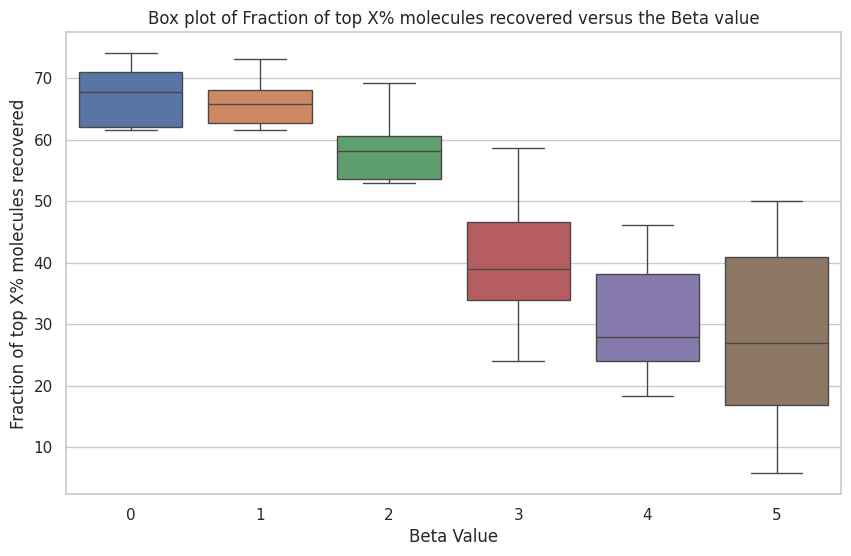

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

list_of_lists_100

# Flatten the list of lists
flat_data_100 = [inner_list[0] for inner_list in list_of_lists_100]

# Create a DataFrame with each sublist as a separate column
df_list_of_lists_100_inverted = pd.DataFrame(flat_data_100).T

# Rename the columns if needed
df_list_of_lists_100_inverted.columns = [f'Column {i+1}' for i in range(len(df_list_of_lists_100_inverted.columns))]

#Need to change the names of the collumns depending on the experimental Initialization size

df_list_of_lists_100_inverted.columns = ['0', '1','2', '3', '4', '5']
df_list_of_lists_100_inverted.index = df_list_of_lists_100_inverted.index + 1
df_list_of_lists_100_inverted

# Box plot Top X

plt.figure(figsize=(10, 6))
sns.boxplot(data=df_list_of_lists_100_inverted, showfliers=False)

plt.title('Box plot of Fraction of top X% molecules recovered versus the Beta value')
plt.ylabel('Fraction of top X% molecules recovered')
plt.xlabel('Beta Value')

plt.show()

In [ ]:
#To copy the dataframe if we need it later
df_list_of_lists_100_inverted

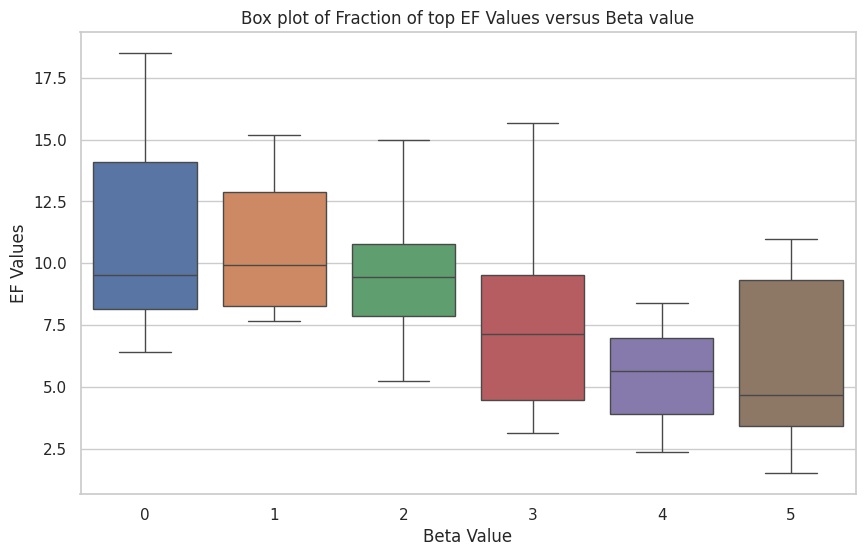

In [ ]:
# Box plot EF

# Flatten the list of lists
flat_data_EF = [inner_list[0] for inner_list in list_of_lists_EF]

# Create a DataFrame with each sublist as a separate column
df_list_of_lists_EF_inverted = pd.DataFrame(flat_data_EF).T

# Rename the columns if needed
df_list_of_lists_EF_inverted.columns = [f'Column {i+1}' for i in range(len(df_list_of_lists_EF_inverted.columns))]
'''
Need to change the names of the collumns depending on the experimental Initialization size
'''
df_list_of_lists_EF_inverted.columns = ['0', '1','2', '3', '4', '5']
df_list_of_lists_EF_inverted.index = df_list_of_lists_EF_inverted.index + 1
df_list_of_lists_EF_inverted

plt.figure(figsize=(10, 6))
sns.boxplot(data=df_list_of_lists_EF_inverted, showfliers=False)

plt.title('Box plot of Fraction of top EF Values versus Beta value')
plt.ylabel('EF Values')
plt.xlabel('Beta Value')

plt.show()

In [ ]:
df_list_of_lists_EF_inverted

,0,1,2,3,4,5
1,17.750000,11.000000,7.875000,3.909091,6.000000,52.000000
2,6.400000,8.000000,7.857143,9.800000,4.714286,4.750000
3,7.777778,9.714286,11.000000,4.222222,2.375000,3.400000
4,9.625000,15.200000,9.000000,15.666667,6.857143,8.800000
5,12.666667,13.500000,9.857143,5.142857,7.833333,1.500000
6,9.428571,7.666667,19.333333,8.166667,5.250000,2.666667
7,14.600000,8.125000,10.166667,8.750000,3.222222,11.000000
8,18.500000,35.500000,5.250000,6.100000,8.400000,4.571429
9,6.800000,10.142857,15.000000,3.125000,7.000000,3.428571
10,9.333333,8.750000,6.000000,14.500000,3.625000,9.500000


#Let's define some functions:

In [ ]:
import pandas as pd
import numpy as np
import umap
import matplotlib.pyplot as plt
import matplotlib.cm as cm

def umap_visualization(csv_file, csv_explore):
    # Read the CSV file into a pandas DataFrame
    data = pd.read_csv(csv_file)
    explore = pd.read_csv(csv_explore)

    # Extract common SMILES
    data_smiles = set(data['Smiles'])
    explore_smiles = set(explore['smiles'])
    common_smiles = data_smiles.intersection(explore_smiles)

    # Filter data to select only rows with common SMILES
    common_data = data[data['Smiles'].isin(common_smiles)]


    # Select all columns containing "FP" as fingerprints
    fingerprint_cols = [col for col in data.columns if 'FP' in col]
    common_fingerprint_cols = [col for col in common_data.columns if 'FP' in col]


    # Identify the score column as the last column in the DataFrame
    score_col = data.columns[-1]
    common_score_col = common_data.columns[-1]

    # Extract features (fingerprints) and labels (scores)
    features = data[fingerprint_cols].values
    common_features = common_data[fingerprint_cols].values
    labels = data[score_col].values
    common_labels = common_data[score_col].values

    # Perform UMAP dimensionality reduction
    reducer = umap.UMAP(random_state=42)
    embedding = reducer.fit_transform(features)
    embedding_2 = reducer.transform(common_features)

    #scaling the scale

    vmin = min(labels.min(), common_labels.min())
    vmax = max(labels.max(), common_labels.max())

    sm = cm.ScalarMappable(cmap='Greys', norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm.set_array([])
    cbar = plt.colorbar(sm, label='Score')

    # Plot the UMAP visualization
    plt.figure(figsize=(10, 6))
    plt.scatter(embedding[:, 0], embedding[:, 1], c=labels, cmap='Greys', s=10)
    plt.scatter(embedding_2[:,0],embedding_2[:,1], color = 'green', s=10)
    plt.title('UMAP Visualization')
    plt.xlabel('UMAP Dimension 1')
    plt.ylabel('UMAP Dimension 2')
    plt.show()

def Molpal_run(model, confid, metrics, init, batches, max_iter, k, BETA):
    !molpal run --write-intermediate --write-final --retrain-from-scratch --library /content/molpal/data/Enamine10k_scores.csv.gz -o lookup --objective-config /content/molpal/examples/objective/Enamine10k_lookup.ini \
        --model {model} --conf-method {confid} --metric {metrics} --init-size {init} \
        --batch-size {batches} --max-iters {max_iter} --fps /content/molpal/folder_output/fps_file.h5 \
        --output-dir run_output -k {k} --beta {BETA}
    !mv /content/molpal/folder_output/run_output/all_explored_final.csv /content/molpal/folder_output/run_output/all_explored_final_beta_{BETA}.csv
    !mv /content/molpal/folder_output/run_output /content/molpal/folder_output/run_output_beta_{BETA}

def frac_top_x(top_x, csv_file):

    file_path = '/content/molpal/data/Enamine10k_scores.csv.gz'
    df = pd.read_csv(file_path)

    df_sorted = df.sort_values(by='score', ascending=False)

    top_x_smiles = df_sorted[['smiles', 'score']].iloc[:top_x]

    output_file_path = f'/content/molpal/data/Top_{top_x}_Enamine10k_scores.csv'
    top_x_smiles.to_csv(output_file_path, index=False)

    df_found = pd.read_csv(csv_file)
    df_top_x = pd.read_csv(output_file_path)

    smiles_found = set(df_found['smiles'])
    smiles_top_x = set(df_top_x['smiles'])

    common_smiles = smiles_found.intersection(smiles_top_x)

    num_common_smiles = len(common_smiles)
    print("Fraction of top", top_x, "smiles found:", num_common_smiles / len(smiles_top_x))

def molpal_umap(model, confid, metrics, init, batches, max_iter, top_x, k, BETA):
    smiles_score = '/content/molpal/data/Enamine10k_scores.csv.gz'
    fps = '/content/molpal/folder_output/fps_file.h5'
    create_combined_csv(smiles_score, fps, 'smiles_fps_score.csv')

    Molpal_run(model, confid, metrics, init, batches, max_iter, k, BETA)

    csv_file = '/content/molpal/folder_output/smiles_fps_score.csv'
    smiles_color_csv = f'/content/molpal/folder_output/run_output_beta_{BETA}/all_explored_final_beta_{BETA}.csv'
    umap_visualization(csv_file, smiles_color_csv)

    top_file = f'/content/molpal/folder_output/run_output_beta_{BETA}/all_explored_final_beta_{BETA}.csv'

    frac_top_x(top_x, top_file)

Exemple of use: - Add 4 runs

***********************************************************************
*   __    __     ______     __         ______   ______     __         *
*  /\ "-./  \   /\  __ \   /\ \       /\  == \ /\  __ \   /\ \        *
*  \ \ \-./\ \  \ \ \/\ \  \ \ \____  \ \  _-/ \ \  __ \  \ \ \____   *
*   \ \_\ \ \_\  \ \_____\  \ \_____\  \ \_\    \ \_\ \_\  \ \_____\  *
*    \/_/  \/_/   \/_____/   \/_____/   \/_/     \/_/\/_/   \/_____/  *
*                                                                     *
***********************************************************************
Welcome to MolPAL!
MolPAL will be run with the following arguments:
  batch_sizes: [5]
  beta: 1
  budget: 1.0
  cache: False
  checkpoint_file: None
  chkpt_freq: 0
  cluster: False
  config: None
  cxsmiles: False
  delimiter: ,
  delta: 0.01
  epsilon: 0.0
  fingerprint: pair
  fps: /content/molpal/folder_output/fps_file.h5
  init_size: 0.005
  invalid_idxs: None
  k: 1000
  length: 2048
  libraries: ['/content/molpal

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
<ipython-input-31-397438057b07>:48: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, label='Score')


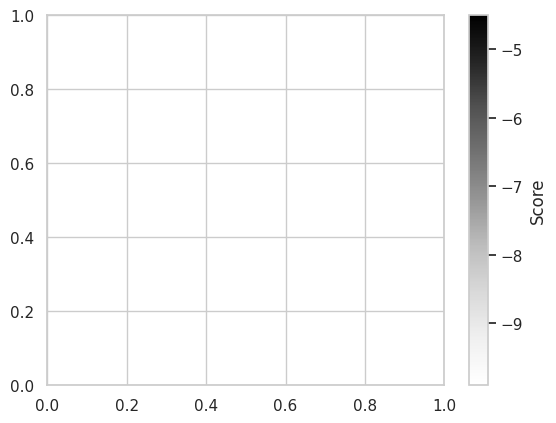

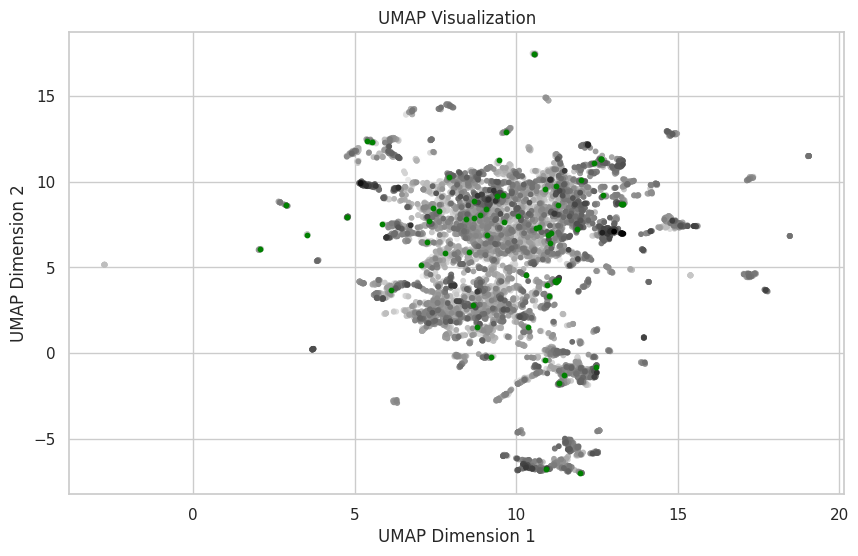

Fraction of top 100 smiles found: 0.0


In [ ]:
molpal_umap('rf','mve', 'ucb', 0.005, 5, 2, 100,1000,1)

## 3.3 Determining the Enhencement Factor

In [ ]:
#def experiment_top_ef(model, confid, metrics, init, batches, max_iter, dataset, top_x_perc, k, BETA):
experiment_top_ef('rf','mve', 'ucb', 500, 160, 5, 10, 0.01, 1000, 2)

## 3.4 Finding the optimal top X % recovered molecules

Idée est de trouver les conditions pour retrouver la plus grande majorité top X% molecules actives

In [ ]:
array_frac_100_rf = []

#ini = [100, 400, 800]
#batches = [100, 33, 20, 14, 10]
#iters = [10, 30, 50, 70 ,100]

ini = [10, 100, 1000]
batches = [10, 50, 100]
iters = [10, 20, 100]

# Loop through each value of ini
for i in range(len(ini)):
    # List to store frac values for the current ini
    array_frac_ini_rf = []

    for j in range(len(batches)):
        # Call experiment_top_ef with corresponding ini, batches, and iters values
        frac, EF = experiment_top_ef('rf', 'mve', 'ucb', ini[i], batches[j], iters[j], 10, 0.01, 1000, 2)
        array_frac_ini_rf.append(frac)

    # Create DataFrame for Fraction for the current ini
    df_frac_ini = pd.DataFrame({'Batches': batches, 'Fraction': array_frac_ini_rf})

    # Plot Fraction vs. Batch Size for the current ini
    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(8, 6))
    sns.lineplot(x='Batches', y='Fraction', data=df_frac_ini, marker='o')

    plt.title(f'Fraction of molecules recovered vs. Batch Size (ini = {ini[i]})', fontsize=16)
    plt.xlabel('Batch Size', fontsize=14)
    plt.ylabel('Fraction of molecules recovered', fontsize=14)
    plt.xticks(batches)
    plt.grid(True)

    plt.tight_layout()
    plt.show()


## 3.5 Effect of the batch size on the active learning performance

In [ ]:
array_frac_100_rf = []
array_EF_rf = []

#batches = [2,5,10,20,40,60,80,100]
#iters = [224, 89, 45, 22, 11, 8, 6, 5]

#batches = [10,20,30,40,60]
#iters = [60 ,30, 20, 15, 10]

batches = [10,20,30]
iters = [60 ,30, 20]

for i in range(len(batches)):

  frac,EF = experiment_top_ef('rf', 'mve', 'ucb', 100, batches[i], iters[i], 10, 0.01, 1000, 2)

  array_frac_100_rf.append(frac)
  array_EF_rf.append(EF)



df_ef = pd.DataFrame({'Batches': batches, 'Enrichment Factor': array_EF_rf})


df_frac = pd.DataFrame({'Batches': batches, 'Fraction': array_frac_100_rf})


sns.set_theme(style="whitegrid")
plt.figure(figsize=(16, 6))


plt.subplot(1, 2, 1)
sns.lineplot(x='Batches', y='Enrichment Factor', data=df_ef, marker='o')

plt.title('Enrichment Factor vs. Batch Size', fontsize=16)
plt.xlabel('Batch Size', fontsize=14)
plt.ylabel('Enrichment Factor (EF)', fontsize=14)
plt.xticks(batches)
plt.grid(True)


plt.subplot(1, 2, 2)
sns.lineplot(x='Batches', y='Fraction', data=df_frac, marker='o')

plt.title('Fraction of molecule recovered vs. Batch Size', fontsize=16)
plt.xlabel('Batch Size', fontsize=14)
plt.ylabel('Fraction of molecules recovered', fontsize=14)
plt.xticks(batches)
plt.grid(True)

plt.tight_layout()
plt.show()


## 3.6.1 Effect of the initialization size & max_iter effect of the active learning performance

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


#run_nbr = [1 ,2, 3, 4, 5, 6, 7, 8, 9, 10]

run_nbr = [1 ,2]
array_frac_100_rf = []
array_EF_rf = []
list_of_lists_100 = []
list_of_lists_EF = []

#ini = [0, 100, 200, 300, 400, 500]
#max_iter = [30, 25, 20, 15, 10, 5]

ini = [ 499, 500]
max_iter = [ 5, 5]


for i in range(len(ini)):

  for j in range(len(run_nbr)):

    frac,EF = experiment_multirun('rf', 'mve', 'ucb', ini[i], 20, max_iter[i], 10, 0.01, 1000, 2, 1)
    array_frac_100_rf.append(frac)
    array_EF_rf.append(EF)

  list_of_lists_100.append([array_frac_100_rf])
  list_of_lists_EF.append([array_EF_rf])

  array_frac_100_rf = []
  array_EF_rf = []


average_EF = [np.mean(values) for values in list_of_lists_EF]
std_devs_EF = [np.std(values) for values in list_of_lists_EF]

average_100 = [np.mean(values) for values in list_of_lists_100]
std_devs_100 = [np.std(values) for values in list_of_lists_100]

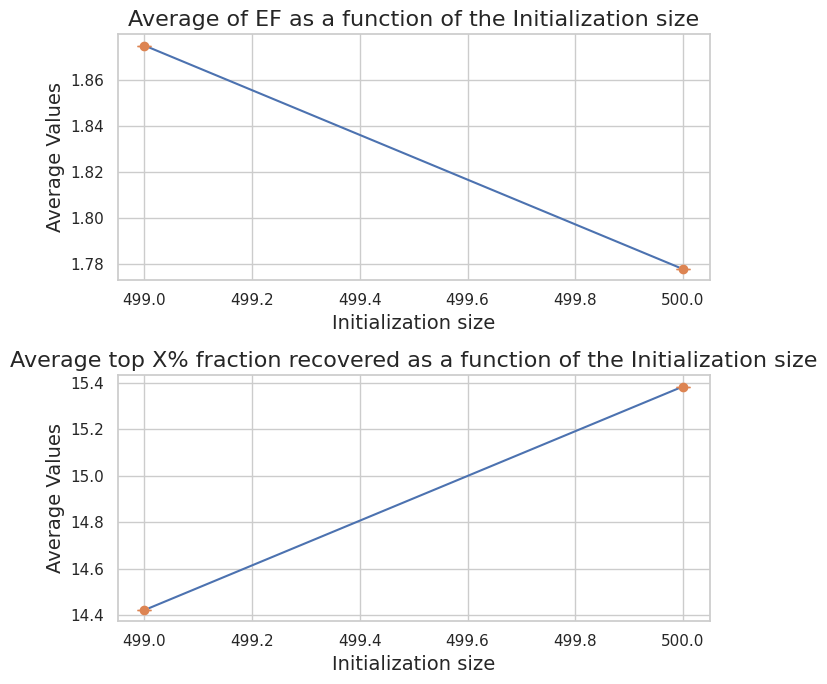

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Define data for the first subplot
data1 = {
    'Initialization size': ini,
    'Average Value': average_100,
}
df1 = pd.DataFrame(data1)

# Define data for the second subplot
data2 = {
    'Initialization size': ini,
    'Average Value': average_EF,
}
df2 = pd.DataFrame(data2)


# Create subplots
fig, axs = plt.subplots(2, 1, figsize=(7, 7))

# Plot EF data with error bars using Seaborn in the first subplot
sns.lineplot(x='Initialization size', y='Average Value', data=df2, marker='o', ax=axs[0])

# Add error bars to the first subplot
axs[0].errorbar(ini, average_EF, yerr=std_devs_EF, fmt='o', capsize=5)

# Add labels and title to the first subplot
axs[0].set_title('Average of EF as a function of the Initialization size', fontsize=16)
axs[0].set_xlabel('Initialization size', fontsize=14)
axs[0].set_ylabel('Average Values', fontsize=14)
axs[0].grid(True)

# Plot top X% fraction recovered data with error bars using Seaborn in the second subplot
sns.lineplot(x='Initialization size', y='Average Value', data=df1, marker='o', ax=axs[1])

# Add error bars to the second subplot
axs[1].errorbar(ini, average_100, yerr=std_devs_100, fmt='o', capsize=5)

# Add labels and title to the second subplot
axs[1].set_title('Average top X% fraction recovered as a function of the Initialization size', fontsize=16)
axs[1].set_xlabel('Initialization size', fontsize=14)
axs[1].set_ylabel('Average Values', fontsize=14)
axs[1].grid(True)


plt.tight_layout()
plt.show()

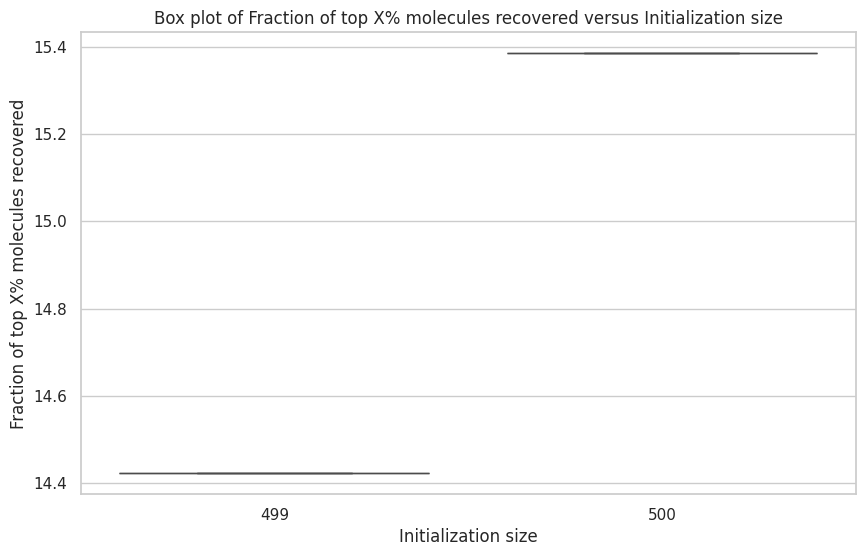

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

list_of_lists_100

# Flatten the list of lists
flat_data_100 = [inner_list[0] for inner_list in list_of_lists_100]

# Create a DataFrame with each sublist as a separate column
df_list_of_lists_100_inverted = pd.DataFrame(flat_data_100).T

# Rename the columns if needed
df_list_of_lists_100_inverted.columns = [f'Column {i+1}' for i in range(len(df.columns))]
'''
Need to change the names of the collumns depending on the experimental Initialization size
'''
#df_list_of_lists_100_inverted.columns = ['0', '100','200', '300', '400', '500']
df_list_of_lists_100_inverted.columns = ['499', '500']
df_list_of_lists_100_inverted.index = df_list_of_lists_100_inverted.index + 1
df_list_of_lists_100_inverted

# Box plot Top X

plt.figure(figsize=(10, 6))
sns.boxplot(data=df_list_of_lists_100_inverted)

plt.title('Box plot of Fraction of top X% molecules recovered versus Initialization size')
plt.ylabel('Fraction of top X% molecules recovered')
plt.xlabel('Initialization size')

plt.show()

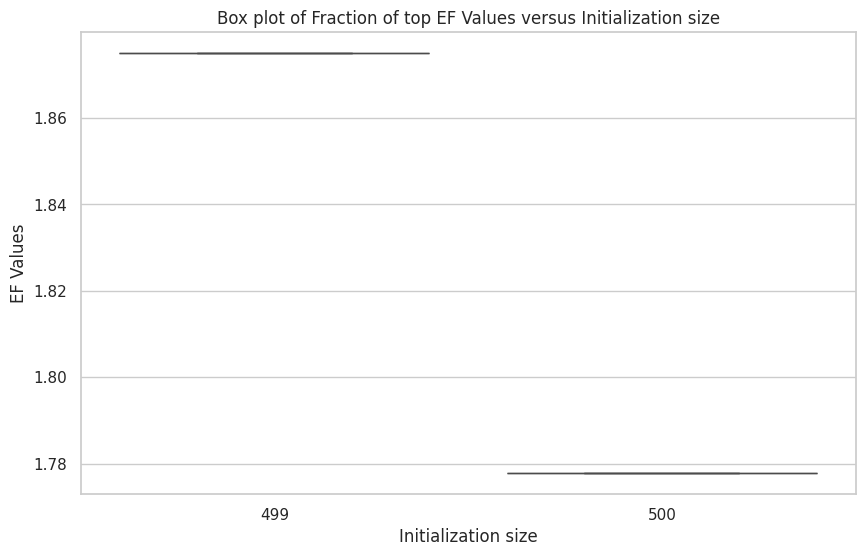

In [ ]:
# Box plot EF

# Flatten the list of lists
flat_data_EF = [inner_list[0] for inner_list in list_of_lists_EF]

# Create a DataFrame with each sublist as a separate column
df_list_of_lists_EF_inverted = pd.DataFrame(flat_data_EF).T

# Rename the columns if needed
df_list_of_lists_EF_inverted.columns = [f'Column {i+1}' for i in range(len(df.columns))]
'''
Need to change the names of the collumns depending on the experimental Initialization size
'''
#df_list_of_lists_EF_inverted.columns = ['0', '100','200', '300', '400', '500']
df_list_of_lists_EF_inverted.columns = ['499', '500']
df_list_of_lists_EF_inverted.index = df_list_of_lists_EF_inverted.index + 1
df_list_of_lists_EF_inverted

plt.figure(figsize=(10, 6))
sns.boxplot(data=df_list_of_lists_EF_inverted)

plt.title('Box plot of Fraction of top EF Values versus Initialization size')
plt.ylabel('EF Values')
plt.xlabel('Initialization size')

plt.show()

# 3.6.2 Effect of the initialization size & batch size on the active learning performance
#Resart Env avant de lancer la eduxièem run!!


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


run_nbr = [1 ,2, 3, 4, 5, 6, 7, 8, 9, 10]


array_frac_100_rf = []
array_EF_rf = []
list_of_lists_100 = []
list_of_lists_EF = []

ini = [0, 100, 200, 300, 400, 500]
batches = [24, 20, 16, 12, 8, 4]




for i in range(len(ini)):

  for j in range(len(run_nbr)):

    frac,EF = experiment_multirun('rf', 'mve', 'ucb', ini[i], batches[i], 25, 10, 0.01, 1000, 2, 1)
    array_frac_100_rf.append(frac)
    array_EF_rf.append(EF)

  list_of_lists_100.append([array_frac_100_rf])
  list_of_lists_EF.append([array_EF_rf])

  array_frac_100_rf = []
  array_EF_rf = []


average_EF = [np.mean(values) for values in list_of_lists_EF]
std_devs_EF = [np.std(values) for values in list_of_lists_EF]

average_100 = [np.mean(values) for values in list_of_lists_100]
std_devs_100 = [np.std(values) for values in list_of_lists_100]

***********************************************************************
*   __    __     ______     __         ______   ______     __         *
*  /\ "-./  \   /\  __ \   /\ \       /\  == \ /\  __ \   /\ \        *
*  \ \ \-./\ \  \ \ \/\ \  \ \ \____  \ \  _-/ \ \  __ \  \ \ \____   *
*   \ \_\ \ \_\  \ \_____\  \ \_____\  \ \_\    \ \_\ \_\  \ \_____\  *
*    \/_/  \/_/   \/_____/   \/_____/   \/_/     \/_/\/_/   \/_____/  *
*                                                                     *
***********************************************************************
Welcome to MolPAL!
MolPAL will be run with the following arguments:
  batch_sizes: [8]
  beta: 2
  budget: 1.0
  cache: False
  checkpoint_file: None
  chkpt_freq: 0
  cluster: False
  config: None
  cxsmiles: False
  delimiter: ,
  delta: 0.01
  epsilon: 0.0
  fingerprint: pair
  fps: /content/molpal/folder_output/fps_file.h5
  init_size: 499
  invalid_idxs: None
  k: 1000
  length: 2048
  libraries: ['/content/molpal/d

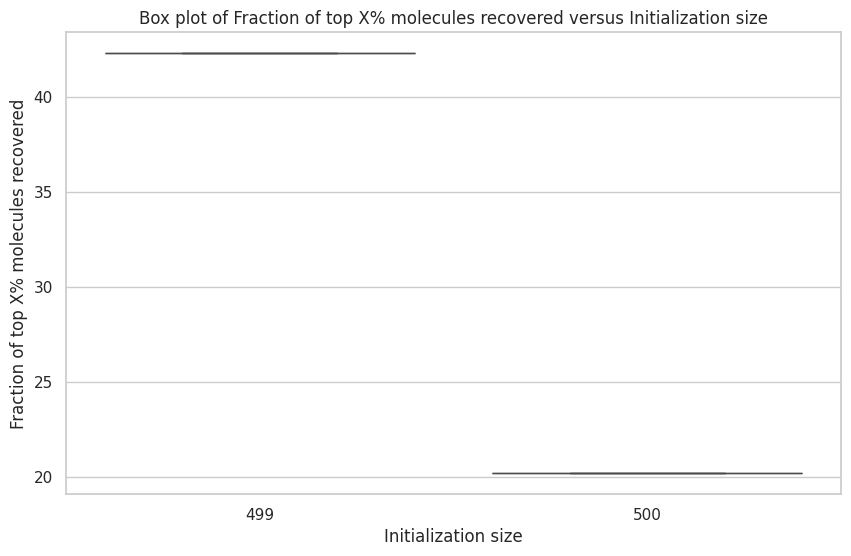

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

list_of_lists_100

# Flatten the list of lists
flat_data_100 = [inner_list[0] for inner_list in list_of_lists_100]

# Create a DataFrame with each sublist as a separate column
df_list_of_lists_100_inverted = pd.DataFrame(flat_data_100).T

# Rename the columns if needed
df_list_of_lists_100_inverted.columns = [f'Column {i+1}' for i in range(len(df.columns))]
'''
Need to change the names of the collumns depending on the experimental Initialization size
'''
#df_list_of_lists_100_inverted.columns = ['0', '100','200', '300', '400', '500']
df_list_of_lists_100_inverted.columns = ['499', '500']
df_list_of_lists_100_inverted.index = df_list_of_lists_100_inverted.index + 1
df_list_of_lists_100_inverted

# Box plot Top X

plt.figure(figsize=(10, 6))
sns.boxplot(data=df_list_of_lists_100_inverted)

plt.title('Box plot of Fraction of top X% molecules recovered versus Initialization size')
plt.ylabel('Fraction of top X% molecules recovered')
plt.xlabel('Initialization size')

plt.show()

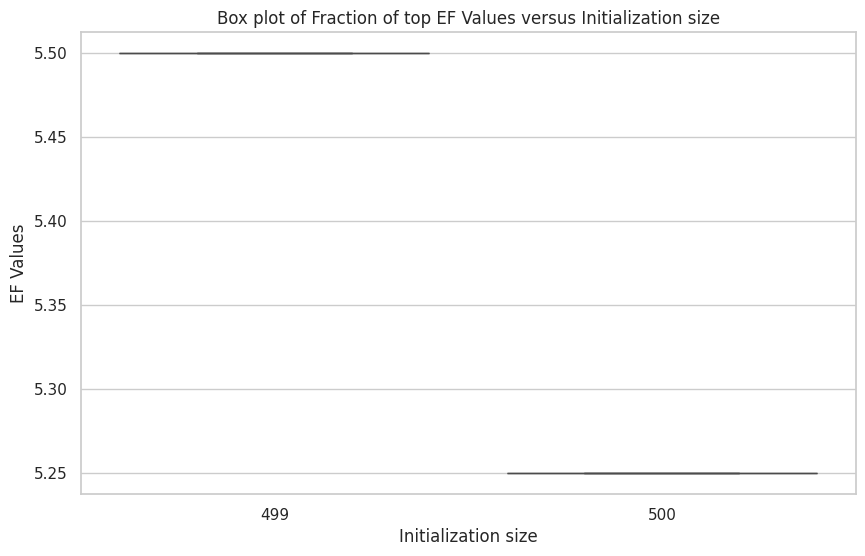

In [ ]:
# Box plot EF

# Flatten the list of lists
flat_data_EF = [inner_list[0] for inner_list in list_of_lists_EF]

# Create a DataFrame with each sublist as a separate column
df_list_of_lists_EF_inverted = pd.DataFrame(flat_data_EF).T

# Rename the columns if needed
df_list_of_lists_EF_inverted.columns = [f'Column {i+1}' for i in range(len(df.columns))]
'''
Need to change the names of the collumns depending on the experimental Initialization size
'''
#df_list_of_lists_EF_inverted.columns = ['0', '100','200', '300', '400', '500']
df_list_of_lists_EF_inverted.columns = ['499', '500']
df_list_of_lists_EF_inverted.index = df_list_of_lists_EF_inverted.index + 1
df_list_of_lists_EF_inverted

plt.figure(figsize=(10, 6))
sns.boxplot(data=df_list_of_lists_EF_inverted)

plt.title('Box plot of Fraction of top EF Values versus Initialization size')
plt.ylabel('EF Values')
plt.xlabel('Initialization size')

plt.show()

# 3.7 Measurement of the variability between runs

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


run_nbr = [1 ,2]
array_frac_100_rf = []
array_EF_rf = []
list_of_lists_100 = []
list_of_lists_EF = []

batches = [100, 250]
iters = [5, 2]


for i in range(len(batches)):

  for j in range(len(run_nbr)):
    frac,EF = experiment_multirun('rf', 'mve', 'ucb', 100, batches[i], iters[i], 10, 0.01, 1000, 2, run_nbr[j])
    array_frac_100_rf.append(frac)
    array_EF_rf.append(EF)

  list_of_lists_100.append([array_frac_100_rf])
  list_of_lists_EF.append([array_EF_rf])

  array_frac_100_rf = []
  array_EF_rf = []


average_EF = [np.mean(values) for values in list_of_lists_EF]
std_devs_EF = [np.std(values) for values in list_of_lists_EF]

average_100 = [np.mean(values) for values in list_of_lists_100]
std_devs_100 = [np.std(values) for values in list_of_lists_100]





***********************************************************************
*   __    __     ______     __         ______   ______     __         *
*  /\ "-./  \   /\  __ \   /\ \       /\  == \ /\  __ \   /\ \        *
*  \ \ \-./\ \  \ \ \/\ \  \ \ \____  \ \  _-/ \ \  __ \  \ \ \____   *
*   \ \_\ \ \_\  \ \_____\  \ \_____\  \ \_\    \ \_\ \_\  \ \_____\  *
*    \/_/  \/_/   \/_____/   \/_____/   \/_/     \/_/\/_/   \/_____/  *
*                                                                     *
***********************************************************************
Welcome to MolPAL!
MolPAL will be run with the following arguments:
  batch_sizes: [100]
  beta: 2
  budget: 1.0
  cache: False
  checkpoint_file: None
  chkpt_freq: 0
  cluster: False
  config: None
  cxsmiles: False
  delimiter: ,
  delta: 0.01
  epsilon: 0.0
  fingerprint: pair
  fps: /content/molpal/folder_output/fps_file.h5
  init_size: 100
  invalid_idxs: None
  k: 1000
  length: 2048
  libraries: ['/content/molpal

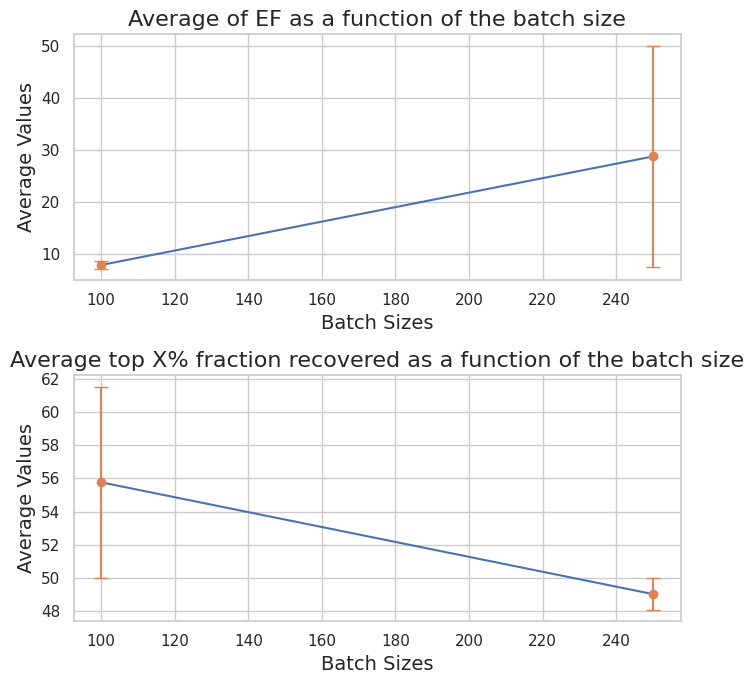

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Define data for the first subplot
data1 = {
    'Batch Size': batches,
    'Average Value': average_100,
}
df1 = pd.DataFrame(data1)

# Define data for the second subplot
data2 = {
    'Batch Size': batches,
    'Average Value': average_EF,
}
df2 = pd.DataFrame(data2)


# Create subplots
fig, axs = plt.subplots(2, 1, figsize=(7, 7))

# Plot EF data with error bars using Seaborn in the first subplot
sns.lineplot(x='Batch Size', y='Average Value', data=df2, marker='o', ax=axs[0])

# Add error bars to the first subplot
axs[0].errorbar(batches, average_EF, yerr=std_devs_EF, fmt='o', capsize=5)

# Add labels and title to the first subplot
axs[0].set_title('Average of EF as a function of the batch size', fontsize=16)
axs[0].set_xlabel('Batch Sizes', fontsize=14)
axs[0].set_ylabel('Average Values', fontsize=14)
axs[0].grid(True)

# Plot top X% fraction recovered data with error bars using Seaborn in the second subplot
sns.lineplot(x='Batch Size', y='Average Value', data=df1, marker='o', ax=axs[1])

# Add error bars to the second subplot
axs[1].errorbar(batches, average_100, yerr=std_devs_100, fmt='o', capsize=5)

# Add labels and title to the second subplot
axs[1].set_title('Average top X% fraction recovered as a function of the batch size', fontsize=16)
axs[1].set_xlabel('Batch Sizes', fontsize=14)
axs[1].set_ylabel('Average Values', fontsize=14)
axs[1].grid(True)



plt.tight_layout()
plt.show()

For Top 100

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

list_of_lists_100


# Flatten the list of lists
flat_data_100 = [inner_list[0] for inner_list in list_of_lists_100]

# Create a DataFrame with each sublist as a separate column
df_list_of_lists_100_inverted = pd.DataFrame(flat_data_100).T

# Rename the columns if needed
df_list_of_lists_100_inverted.columns = [f'Column {i+1}' for i in range(len(df.columns))]
'''
Need to change the names of the collumns depending on the experimental batch size
'''
df_list_of_lists_100_inverted.columns = ['25', '50', '83', '100', '125', '250']
df_list_of_lists_100_inverted.index = df.index + 1
df_list_of_lists_100_inverted

fig, axs = plt.subplots(2, 1, figsize=(10, 10))

# Plotting the DataFrame
df_list_of_lists_100_inverted.plot(ax=axs[0], title='Fraction of top X% molecules recovered as a function of the run number', marker='o')
axs[0].set_ylabel('Values')
axs[0].set_xlabel('Index')
axs[0].legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Legend')
plt.show()

In [ ]:
# Scatter plot

df_list_of_lists_100 = pd.DataFrame(flat_data_100)
'''
Need to change the names of the collumns depending on the experimental batch size
'''
df_list_of_lists_100.index = ['25', '50', '83', '100', '125', '250']
plt.figure(figsize=(10, 6))
for column in df_list_of_lists_100.columns:
    plt.scatter(df_list_of_lists_100.index, df_list_of_lists_100[column], label=column, color='blue')

plt.xlabel('Batch size')
plt.ylabel('Fraction of top X% molecules recovered')
plt.title('Scatter Plot Fraction of top X% molecules recovered versus Batch size')
plt.grid(True)
plt.show()

In [ ]:
# Box plot

plt.figure(figsize=(10, 6))
sns.boxplot(data=df_list_of_lists_100_inverted)

plt.title('Box plot of Fraction of top X% molecules recovered versus Batch size')
plt.ylabel('Fraction of top X% molecules recovered')
plt.xlabel('Batch size')

plt.show()

For EF

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

list_of_lists_EF

# Flatten the list of lists
flat_data_EF = [inner_list[0] for inner_list in list_of_lists_EF]

# Create a DataFrame with each sublist as a separate column
df_list_of_lists_EF_inverted = pd.DataFrame(flat_data_EF).T

# Rename the columns if needed
df_list_of_lists_EF_inverted.columns = [f'Column {i+1}' for i in range(len(df.columns))]
'''
Need to change the names of the collumns depending on the experimental batch size
'''
df_list_of_lists_EF_inverted.columns = ['25', '50', '83', '100', '125', '250']
df_list_of_lists_EF_inverted.index = df.index + 1

fig, axs = plt.subplots(2, 1, figsize=(10, 10))

# Plotting the DataFrame
df_list_of_lists_EF_inverted.plot(ax=axs[0], title='EF values as a function of the run number', marker='o')
axs[0].set_ylabel('Values')
axs[0].set_xlabel('Index')
axs[0].legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Legend')
plt.show()

In [ ]:
# Scatter plot

df_list_of_lists_EF = pd.DataFrame(flat_data_EF)
'''
Need to change the names of the collumns depending on the experimental batch size
'''
df_list_of_lists_EF.index = ['25', '50', '83', '100', '125', '250']
plt.figure(figsize=(10, 6))
for column in df_list_of_lists_EF.columns:
    plt.scatter(df_list_of_lists_EF.index, df_list_of_lists_EF[column], label=column, color='blue')

plt.xlabel('Batch size')
plt.ylabel('EF Values')
plt.title('Scatter Plot of EF Values versus Batch size')
plt.grid(True)
plt.show()

In [ ]:
# Box plot

plt.figure(figsize=(10, 6))
sns.boxplot(data=df_list_of_lists_EF_inverted)

plt.title('Box plot of values by column')
plt.ylabel('Fraction of top X% molecules recovered')
plt.xlabel('Batch size')

plt.show()

# **TO DO LIST **

In [ ]:
- plot (avec error bar) des EF avec different models (rf, NN, XGBOOST?, et attention a la quantification d'erreur appropriée)
  Le but est de faire 3 runs pour chaque valeur de EF pour pouvoir obtenir un std dev

- meme plot mais avec les fractions du top x qui nous interesse (voir le plus relevant sur l'article + voir le k qu'on se permet)


- pour meilleur batch on test different init


- pour le meilleur batch + init on test le meilleur beta


- voir si on peut deriver une expression mathematique de tout ca


- UMAP pour les differents beta, pour voir l'influence de beta sur l'exploration de l'UCB


- les differents plot d'UCB (scatter plot, mais le reste je sais pas ce qu'il y a d'autre ????)



#Test with NN and Montecarlo dropout

In [ ]:
!molpal run -h

In [ ]:
#Molpal_run(model, confid, metrics, init, batches, max_iter, dataset, top_x_perc, k, BETA):
Molpal_run('nn','dropout', 'ucb', 0.01, 5, 10, 10, 0.01, 100, 2)

## Experiment avec std dev, plot de EF frac vs batch size of the rf (pas encore plot)


In [ ]:
import numpy as np

# Define function to run experiment and return mean and standard deviation of EF
def run_experiment(batches, iters):
    array_EF_rf = []
    array_frac_rf = []

    for i in range(len(batches)):
        frac, EF = experiment_top_ef('rf', 'mve', 'ucb', 0.01, batches[i], iters[i], 10, 0.01, 100, 5)
        array_EF_rf.append(EF)
        array_frac_rf.append(frac)

    return np.mean(array_EF_rf), np.std(array_EF_rf), np.mean(array_frac_rf), np.std(array_frac_rf)

# Define number of runs
num_runs = 3

# Define batches and iters
batches = [2, 5, 10]
iters = [8, 6, 5]

# Initialize arrays to store mean and std deviation
mean_EF_rf = []
std_dev_EF_rf = []
mean_frac_rf = []
std_dev_frac_rf = []


# Run experiments multiple times
for _ in range(num_runs):
    mean_EF, std_dev_EF, mean_frac, std_dev_frac = run_experiment(batches, iters)
    mean_EF_rf.append(mean_EF)
    std_dev_EF_rf.append(std_dev_EF)
    mean_frac_rf.append(mean_frac)
    std_dev_frac_rf.append(std_dev_frac)

# Calculate mean and std deviation of EF across runs
mean_EF_rf = np.mean(mean_EF_rf, axis=0)
std_dev_EF_rf = np.mean(std_dev_EF_rf, axis=0)
mean_frac_rf = np.mean(mean_EF_rf, axis=0)
std_dev_frac_rf = np.mean(std_dev_frac_rf, axis=0)

# Plot the data with standard deviation bars
df = pd.DataFrame({
    'Batches': batches,
    'Enrichment Factor': mean_EF_rf,
    'Std Deviation EF': std_dev_EF_rf,
    'Frac Top X': mean_frac_rf,
    'Std Deviation frac': std_dev_frac_rf
})

fig, axs = plt.subplots(2, figsize=(10, 12))

# Plot Enrichment Factor
axs[0].errorbar(mean_EF_rf.index, mean_EF_rf, yerr=std_dev_EF_rf, fmt='o-', label='Enrichment Factor')
axs[0].set_title('Enrichment Factor vs. Batch Size')
axs[0].set_xlabel('Batch Size')
axs[0].set_ylabel('Enrichment Factor (EF)')
axs[0].grid(True)
axs[0].legend()

# Plot Fraction of Top X
axs[1].errorbar(mean_frac_rf.index, mean_frac_rf, yerr=std_dev_frac_rf, fmt='o-', color='orange', label='Fraction of Top X')
axs[1].set_title('Fraction of Top X vs. Batch Size')
axs[1].set_xlabel('Batch Size')
axs[1].set_ylabel('Fraction of Top X')
axs[1].grid(True)
axs[1].legend()

plt.tight_layout()
plt.show()


***********************************************************************
*   __    __     ______     __         ______   ______     __         *
*  /\ "-./  \   /\  __ \   /\ \       /\  == \ /\  __ \   /\ \        *
*  \ \ \-./\ \  \ \ \/\ \  \ \ \____  \ \  _-/ \ \  __ \  \ \ \____   *
*   \ \_\ \ \_\  \ \_____\  \ \_____\  \ \_\    \ \_\ \_\  \ \_____\  *
*    \/_/  \/_/   \/_____/   \/_____/   \/_/     \/_/\/_/   \/_____/  *
*                                                                     *
***********************************************************************
Welcome to MolPAL!
MolPAL will be run with the following arguments:
  batch_sizes: [2]
  beta: 5
  budget: 1.0
  cache: False
  checkpoint_file: None
  chkpt_freq: 0
  cluster: False
  config: None
  cxsmiles: False
  delimiter: ,
  delta: 0.01
  epsilon: 0.0
  fingerprint: pair
  fps: /content/molpal/folder_output/fps_file.h5
  init_size: 0.01
  invalid_idxs: None
  k: 100
  length: 2048
  libraries: ['/content/molpal/d

FileNotFoundError: [Errno 2] No such file or directory: '/content/molpal/folder_output/run_output_rf_random_0.01_2_8_beta_5/all_explored_final_rf_random_0.01_2_8_beta_5.csv'

## 3.8 Effect of the Aquirer on the active learning performance

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


run_nbr = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
array_frac_100_rf = []
array_EF_rf = []
list_of_lists_100 = []
list_of_lists_EF = []

aquirer = ['pi', 'ts', 'ucb', 'thompson']


for i in range(len(aquirer)):

  for j in range(len(run_nbr)):
    frac = experiment_multirun2('rf', 'mve', aquirer[i], 100, 20, 25, 10, 0.01, 1000, 1, run_nbr[j])
    array_frac_100_rf.append(frac)


  list_of_lists_100.append([array_frac_100_rf])
  array_frac_100_rf = []

average_100 = [np.mean(values) for values in list_of_lists_100]
std_devs_100 = [np.std(values) for values in list_of_lists_100]

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  n_estimators: 100
  ncpu: 1
  objective: lookup
  objective_config: /content/molpal/examples/objective/Enamine10k_lookup.ini
  output_dir: run_output
  pool: eager
  previous_scores: None
  prune: False
  radius: 2
  retrain_from_scratch: True
  scores_csvs: None
  seed: None
  smiles_col: 0
  test_batch_size: None
  title_line: True
  verbose: 0
  window_size: 3
  write_final: True
  write_intermediate: True

/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-05-20 16:40:09,159	INFO worke

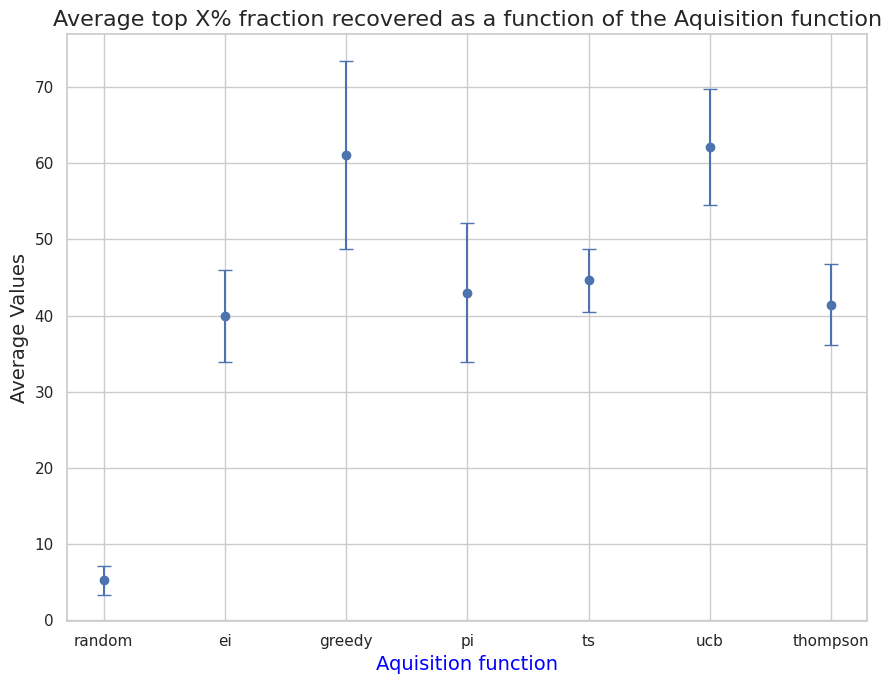

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Sample data
data = {
    'random': [5.769231, 5.769231, 5.769231, 9.615385, 4.807692, 2.884615, 4.807692, 3.846154, 6.730769, 2.884615],
    'ei': [38.461538, 28.846154, 29.807692, 40.384615, 41.346154, 46.153846, 48.076923, 43.269231, 39.423077, 44.230769],
    'greedy': [69.230769, 45.192308, 63.461538, 40.384615, 47.115385, 72.115385, 55.769231, 75.961538, 74.038462, 67.307692],
    'pi': [25.9615384615384, 35.576923076923, 50.9615384615384, 50.9615384615384, 37.5, 53.8461538461538, 51.9230769230769, 48.076923076923, 42.3076923076923, 32.6923076923076],
    'ts': [49.0384615384615, 41.3461538461538, 51.9230769230769, 50, 39.4230769230769, 45.1923076923076, 45.1923076923076, 42.3076923076923, 40.3846153846153, 41.3461538461538],
    'ucb': [47.1153846153846, 63.4615384615384, 55.7692307692307, 67.3076923076923, 66.3461538461538, 65.3846153846153, 70.1923076923077, 57.6923076923076, 73.076923076923, 54.8076923076923],
    'thompson': [50, 42.3076923076923, 48.076923076923, 41.3461538461538, 37.5, 43.2692307692307, 38.4615384615384, 43.2692307692307, 40.3846153846153, 29.8076923076923]
}

# Create DataFrame
df = pd.DataFrame(data)

# Convert DataFrame to list of lists of lists
list_of_lists = [df[column].tolist() for column in df.columns]

# Calculate average and standard deviation
average_100 = [np.mean(values) for values in list_of_lists]
std_devs_100 = [np.std(values) for values in list_of_lists]

# Define the acquisition functions
aquirer = ['random', 'ei', 'greedy', 'pi', 'ts', 'ucb', 'thompson']

# Create DataFrame for plotting
data1 = {
    'Aquisition function': aquirer,
    'Average Value': average_100,
    'Standard Deviation': std_devs_100
}
df1 = pd.DataFrame(data1)

# Plotting
fig, ax = plt.subplots(figsize=(9, 7))

# Plot with error bars
sns.scatterplot(x='Aquisition function', y='Average Value', data=df1, marker='o', ax=ax)
ax.errorbar(aquirer, average_100, yerr=std_devs_100, fmt='o', capsize=5)

# Add labels and title
ax.set_title('Average top X% fraction recovered as a function of the Aquisition function', fontsize=16)
ax.set_xlabel('Aquisition function', fontsize=14, color = "blue")
ax.set_ylabel('Average Values', fontsize=14)
ax.grid(True)

plt.tight_layout()
plt.show()


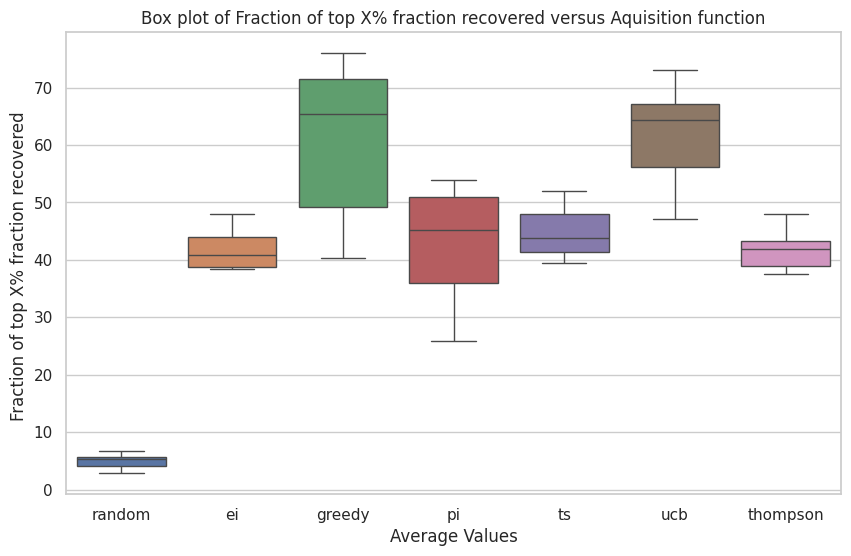

In [ ]:
import pandas as pd
from io import StringIO

# Text data
data = """random ei greedy pi ts ucb thompson
5.769231 38.461538 69.230769 25.9615384615384 49.0384615384615 47.1153846153846 50
5.769231 28.846154 45.192308 35.576923076923 41.3461538461538 63.4615384615384 42.3076923076923
5.769231 29.807692 63.461538 50.9615384615384 51.9230769230769 55.7692307692307 48.076923076923
9.615385 40.384615 40.384615 50.9615384615384 50 67.3076923076923 41.3461538461538
4.807692 41.346154 47.115385 37.5 39.4230769230769 66.3461538461538 37.5
2.884615 46.153846 72.115385 53.8461538461538 45.1923076923076 65.3846153846153 43.2692307692307
4.807692 48.076923 55.769231 51.9230769230769 45.1923076923076 70.1923076923077 38.4615384615384
3.846154 43.269231 75.961538 48.076923076923 42.3076923076923 57.6923076923076 43.2692307692307
6.730769 39.423077 74.038462 42.3076923076923 40.3846153846153 73.076923076923 40.3846153846153
2.884615 44.230769 67.307692 32.6923076923076 41.3461538461538 54.8076923076923 29.8076923076923"""

# Use StringIO to convert the string data to a file-like object
data = StringIO(data)

# Read the data into a DataFrame
df_100 = pd.read_csv(data, sep=" ")

#df_list_of_lists_EF_inverted.columns = ['0', '100','200', '300', '400', '500']
df_100.columns = ['random', 'ei', 'greedy', 'pi', 'ts', 'ucb', 'thompson']
df_100.index = df_100.index + 1
df_100

plt.figure(figsize=(10, 6))
sns.boxplot(data=df_100, showfliers=False)

plt.title('Box plot of Fraction of top X% fraction recovered versus Aquisition function')
plt.ylabel('Fraction of top X% fraction recovered ')
plt.xlabel('Average Values')

plt.show()

#50 K

In [ ]:
%cd /content/molpal/data/
%ls

In [ ]:
df = pd.read_csv("Enamine50k_scores.csv.gz")

df.drop(columns=["score"], inplace=True)

df.to_csv("Enamine50k_smiles.csv.gz", index=False, columns=["smiles"])

df.head()

In [ ]:
df = pd.read_csv('/content/molpal/data/Enamine50k_scores.csv.gz')

df_sorted = df.sort_values(by='score', ascending=False)

percentile_index = int(len(df_sorted) * 0.01)

top_1per_df = df_sorted.iloc[:percentile_index]

top_1per_df.reset_index(drop=True, inplace=True)

top_1per_df.to_csv('/content/molpal/data/top_1per_scores.csv', index=True)

top_1per_df

In [ ]:
%cd /content/molpal

!mkdir folder_output

In [ ]:
%cd folder_output

In [ ]:
import os

output_file = "fps_file.h5"
if os.path.exists(output_file):
    print("The file exists.")
else:
    print("The file does not exist.")

In [ ]:
def molpal_run50k(model, confid, metrics, init, batches, max_iter, k, BETA, n):
    !molpal run --write-intermediate --write-final --retrain-from-scratch --library /content/molpal/data/Enamine50k_scores.csv.gz -o lookup --objective-config /content/molpal/examples/objective/Enamine50k_lookup.ini \
        --model {model} --conf-method {confid} --metric {metrics} --init-size {init} \
        --batch-size {batches} --max-iters {max_iter} --fps /content/molpal/folder_output/fps_file.h5 \
        --output-dir run_output -k {k} --beta {BETA}

    output_filename_csv = f"/content/molpal/folder_output/run_output/all_explored_final_{model}_{metrics}_{init}_{batches}_{max_iter}_beta_{BETA}_run{n}.csv"
    !mv /content/molpal/folder_output/run_output/all_explored_final.csv {output_filename_csv}

    output_folder_name = f"/content/molpal/folder_output/run_output_{model}_{metrics}_{init}_{batches}_{max_iter}_beta_{BETA}_run{n}"
    !mv /content/molpal/folder_output/run_output {output_folder_name}


def molpal_run_random50k(model, confid, init, batches, max_iter, k, BETA, n):
    !molpal run --write-intermediate --write-final --retrain-from-scratch --library /content/molpal/data/Enamine50k_scores.csv.gz -o lookup --objective-config /content/molpal/examples/objective/Enamine50k_lookup.ini \
        --model {model} --conf-method {confid} --metric random --init-size {init} \
        --batch-size {batches} --max-iters {max_iter} --fps /content/molpal/folder_output/fps_file.h5 \
        --output-dir run_output -k {k} --beta {BETA}

    output_filename_csv = f"/content/molpal/folder_output/run_output/all_explored_final_{model}_random_{init}_{batches}_{max_iter}_beta_{BETA}_run{n}.csv"
    !mv /content/molpal/folder_output/run_output/all_explored_final.csv {output_filename_csv}

    output_folder_name = f"/content/molpal/folder_output/run_output_{model}_random_{init}_{batches}_{max_iter}_beta_{BETA}_run{n}"
    !mv /content/molpal/folder_output/run_output {output_folder_name}


def experiment_multirun50k(model, confid, metrics, init, batches, max_iter, dataset, top_x_perc, k, BETA, n):

      molpal_run50k(model, confid, metrics, init, batches, max_iter, k, BETA, n)
      molpal_run_random50k(model, confid, init, batches, max_iter, k, BETA, n)

      csv_file_random = f'/content/molpal/folder_output/run_output_{model}_random_{init}_{batches}_{max_iter}_beta_{BETA}_run{n}/all_explored_final_{model}_random_{init}_{batches}_{max_iter}_beta_{BETA}_run{n}.csv'
      csv_file = f'/content/molpal/folder_output/run_output_{model}_{metrics}_{init}_{batches}_{max_iter}_beta_{BETA}_run{n}/all_explored_final_{model}_{metrics}_{init}_{batches}_{max_iter}_beta_{BETA}_run{n}.csv'

      frac = frac_top_x(top_x_perc, dataset, csv_file)

      frac_random = frac_top_x(top_x_perc, dataset, csv_file_random)

      print("The percentage of molecules recovered from the top", top_x_perc, "% is", frac, "% for", metrics, "and", frac_random, "% for random")

      EF = frac/frac_random

      print("The Enrichement Factor EF was calculated to be", EF)

      return frac, EF

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


run_nbr = [1 ,2, 3, 4, 5, 6, 7, 8, 9, 10]
array_frac_100_rf = []
array_EF_rf = []
list_of_lists_100 = []
list_of_lists_EF = []

#batches = [40, 45 ,63]
#iters = [63, 56, 40]

batches = [ 45 ]
iters = [ 56 ]


for i in range(len(batches)):

  for j in range(len(run_nbr)):
    frac,EF = experiment_multirun50k('rf', 'mve', 'ucb', 500, batches[i], iters[i], 10, 0.01, 3500, 1, run_nbr[j])
    array_frac_100_rf.append(frac)
    array_EF_rf.append(EF)

  list_of_lists_100.append([array_frac_100_rf])
  list_of_lists_EF.append([array_EF_rf])

  array_frac_100_rf = []
  array_EF_rf = []


average_EF = [np.mean(values) for values in list_of_lists_EF]
std_devs_EF = [np.std(values) for values in list_of_lists_EF]

average_100 = [np.mean(values) for values in list_of_lists_100]
std_devs_100 = [np.std(values) for values in list_of_lists_100]

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

"""
# Sample data
data = {
    'random': [5.769231, 5.769231, 5.769231, 9.615385, 4.807692, 2.884615, 4.807692, 3.846154, 6.730769, 2.884615],
    'ei': [38.461538, 28.846154, 29.807692, 40.384615, 41.346154, 46.153846, 48.076923, 43.269231, 39.423077, 44.230769],
    'greedy': [69.230769, 45.192308, 63.461538, 40.384615, 47.115385, 72.115385, 55.769231, 75.961538, 74.038462, 67.307692],
    'pi': [25.9615384615384, 35.576923076923, 50.9615384615384, 50.9615384615384, 37.5, 53.8461538461538, 51.9230769230769, 48.076923076923, 42.3076923076923, 32.6923076923076],
    'ts': [49.0384615384615, 41.3461538461538, 51.9230769230769, 50, 39.4230769230769, 45.1923076923076, 45.1923076923076, 42.3076923076923, 40.3846153846153, 41.3461538461538],
    'ucb': [47.1153846153846, 63.4615384615384, 55.7692307692307, 67.3076923076923, 66.3461538461538, 65.3846153846153, 70.1923076923077, 57.6923076923076, 73.076923076923, 54.8076923076923],
    'thompson': [50, 42.3076923076923, 48.076923076923, 41.3461538461538, 37.5, 43.2692307692307, 38.4615384615384, 43.2692307692307, 40.3846153846153, 29.8076923076923]
}
"""

# Create DataFrame
df = pd.DataFrame(data)

# Convert DataFrame to list of lists of lists
list_of_lists = [df[column].tolist() for column in df.columns]

# Calculate average and standard deviation
average_100 = [np.mean(values) for values in list_of_lists]
std_devs_100 = [np.std(values) for values in list_of_lists]

# Define the acquisition functions
aquirer = ['random', 'ei', 'greedy', 'pi', 'ts', 'ucb', 'thompson']

# Create DataFrame for plotting
data1 = {
    'Aquisition function': aquirer,
    'Average Value': average_100,
    'Standard Deviation': std_devs_100
}
df1 = pd.DataFrame(data1)

# Plotting
fig, ax = plt.subplots(figsize=(9, 7))

# Plot with error bars
sns.scatterplot(x='Aquisition function', y='Average Value', data=df1, marker='o', ax=ax)
ax.errorbar(aquirer, average_100, yerr=std_devs_100, fmt='o', capsize=5)

# Add labels and title
ax.set_title('Average top X% fraction recovered as a function of the Aquisition function', fontsize=16)
ax.set_xlabel('Aquisition function', fontsize=14, color = "blue")
ax.set_ylabel('Average Values', fontsize=14)
ax.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
from io import StringIO

# Text data
data = """random ei greedy pi ts ucb thompson
5.769231 38.461538 69.230769 25.9615384615384 49.0384615384615 47.1153846153846 50
5.769231 28.846154 45.192308 35.576923076923 41.3461538461538 63.4615384615384 42.3076923076923
5.769231 29.807692 63.461538 50.9615384615384 51.9230769230769 55.7692307692307 48.076923076923
9.615385 40.384615 40.384615 50.9615384615384 50 67.3076923076923 41.3461538461538
4.807692 41.346154 47.115385 37.5 39.4230769230769 66.3461538461538 37.5
2.884615 46.153846 72.115385 53.8461538461538 45.1923076923076 65.3846153846153 43.2692307692307
4.807692 48.076923 55.769231 51.9230769230769 45.1923076923076 70.1923076923077 38.4615384615384
3.846154 43.269231 75.961538 48.076923076923 42.3076923076923 57.6923076923076 43.2692307692307
6.730769 39.423077 74.038462 42.3076923076923 40.3846153846153 73.076923076923 40.3846153846153
2.884615 44.230769 67.307692 32.6923076923076 41.3461538461538 54.8076923076923 29.8076923076923"""

"""
CHANGER DATA SET ICI
"""
# Use StringIO to convert the string data to a file-like object
data = StringIO(data)

# Read the data into a DataFrame
df_100 = pd.read_csv(data, sep=" ")

#df_list_of_lists_EF_inverted.columns = ['0', '100','200', '300', '400', '500']
df_100.columns = ['random', 'ei', 'greedy', 'pi', 'ts', 'ucb', 'thompson']
df_100.index = df_100.index + 1
df_100

plt.figure(figsize=(10, 6))
sns.boxplot(data=df_100, showfliers=False)

plt.title('Box plot of Fraction of top X% fraction recovered versus Aquisition function')
plt.ylabel('Fraction of top X% fraction recovered ')
plt.xlabel('Average Values')

plt.show()

#Tanimoto

In [ ]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs
from rdkit.ML.Cluster import Butina

# Get the top 1% molecules
#df = dataframe avec smiles et score

top_1_percent = df.nlargest(int(len(df) * 0.01), 'score')

top_1_percent['molecule'] = top_1_percent['smiles'].apply(Chem.MolFromSmiles)
top_1_percent['fingerprint'] = top_1_percent['molecule'].apply(lambda x: AllChem.GetMorganFingerprintAsBitVect(x, 2, nBits=2048))
top_1_percent = top_1_percent.drop('molecule', axis =1 )


# to compare two molec similarities
def tanimoto_similarity(fp1, fp2):
    return DataStructs.TanimotoSimilarity(fp1, fp2)

fingerprints = list(top_1_percent['fingerprint'])

dissimilarity_threshold = 0.6
dissimilarity_matrix = []

for i in range(len(fingerprints)):
    similarities = []
    for j in range(i + 1, len(fingerprints)):
        similarity = tanimoto_similarity(fingerprints[i], fingerprints[j])
        similarities.append(similarity)
    dissimilarity_matrix.append(similarities)

clusters = Butina.ClusterData(dissimilarity_matrix, len(fingerprints), dissimilarity_threshold, isDistData=False)

selected_molecules = [top_1_percent.iloc[cluster[0]] for cluster in clusters]

selected_df = pd.DataFrame(selected_molecules)

selected_df

KeyError: 'score'

#Intra-set Tanimoto similarity

In [ ]:
import numpy as np
import pandas as pd
import random
import more_itertools as mit
from rdkit.Chem import AllChem
from rdkit.DataStructs import BulkTanimotoSimilarity

class NCircles:
    def __init__(self, threshold=0.75):
        self.sim_mat_func = similarity_matrix_tanimoto
        self.t = threshold

    def get_circles(self, args):
        vecs, sim_mat_func, t = args
        circs = []

        for vec in vecs:
            if len(circs) > 0:
                dists = 1.0 - sim_mat_func([vec], circs)
                if dists.min() <= t:
                    continue
            circs.append(vec)

        return circs

    def measure1(self, vecs, n_chunk=64):
        for i in range(3):
            chunk_size = max(1, n_chunk // (2 ** i))  # Ensure chunk_size is at least 1
            vecs_list = list(mit.chunked(vecs, chunk_size))
            args = zip(vecs_list, [self.sim_mat_func] * len(vecs_list), [self.t] * len(vecs_list))
            circs_list = list(map(self.get_circles, args))
            vecs = [c for ls in circs_list for c in ls]
            random.shuffle(vecs)

        vecs = self.get_circles((vecs, self.sim_mat_func, self.t))
        return len(vecs), vecs  # Ensure measure returns a tuple

    def measure(self, vecs, n_chunk=64):
        for i in range(3):
            vecs_list = list(mit.divide(n_chunk // (2 ** i), vecs))
            args = zip(vecs_list, [self.sim_mat_func] * len(vecs_list), [self.t] * len(vecs_list))
            circs_list = list(map(self.get_circles, args))
            vecs = [c for ls in circs_list for c in ls]
            random.shuffle(vecs)
        vecs = self.get_circles((vecs, self.sim_mat_func, self.t))
        return len(vecs), vecs



def get_ncircle(df):
    if 'FPS' not in df:
        df['FPS'] = [AllChem.GetMorganFingerprintAsBitVect(mol, 2, 1024) for mol in df['MOL']]
    return NCircles().measure(df['FPS'])


def get_ncircle1(df):
    if 'FPS' not in df:
        df['FPS'] = [AllChem.GetMorganFingerprintAsBitVect(mol, 2, 1024) for mol in df['MOL']]
    n_circles, vecs = NCircles().measure(df['FPS'])  # Ensure it returns a tuple
    return n_circles, vecs

def similarity_matrix_tanimoto(fps1, fps2):
    similarities = [BulkTanimotoSimilarity(fp, fps2) for fp in fps1]
    return np.array(similarities)

def average_agg_tanimoto(stock_vecs, gen_vecs,
                         batch_size=5000, agg='max',
                         device='cpu', p=1):
    """
    For each molecule in gen_vecs finds closest molecule in stock_vecs.
    Returns average tanimoto score for between these molecules

    Parameters:
        stock_vecs: numpy array <n_vectors x dim>
        gen_vecs: numpy array <n_vectors' x dim>
        agg: max or mean
        p: power for averaging: (mean x^p)^(1/p)
    """
    assert agg in ['max', 'mean'], "Can aggregate only max or mean"
    agg_tanimoto = np.zeros(len(gen_vecs))
    total = np.zeros(len(gen_vecs))
    for j in range(0, stock_vecs.shape[0], batch_size):
        x_stock = torch.tensor(stock_vecs[j:j + batch_size]).to(device).float()
        for i in range(0, gen_vecs.shape[0], batch_size):
            y_gen = torch.tensor(gen_vecs[i:i + batch_size]).to(device).float()
            y_gen = y_gen.transpose(0, 1)
            tp = torch.mm(x_stock, y_gen)
            jac = (tp / (x_stock.sum(1, keepdim=True) +
                         y_gen.sum(0, keepdim=True) - tp)).cpu().numpy()
            jac[np.isnan(jac)] = 1
            if p != 1:
                jac = jac**p
            if agg == 'max':
                agg_tanimoto[i:i + y_gen.shape[1]] = np.maximum(
                    agg_tanimoto[i:i + y_gen.shape[1]], jac.max(0))
            elif agg == 'mean':
                agg_tanimoto[i:i + y_gen.shape[1]] += jac.sum(0)
                total[i:i + y_gen.shape[1]] += jac.shape[0]
    if agg == 'mean':
        agg_tanimoto /= total
    if p != 1:
        agg_tanimoto = (agg_tanimoto)**(1/p)
    return np.mean(agg_tanimoto)

def smiles_to_fingerprint(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        return AllChem.GetMorganFingerprintAsBitVect(mol, 2, 1024)
    else:
        return None

def bitvect_to_list(bitvect):
    return [int(bitvect.GetBit(i)) for i in range(bitvect.GetNumBits())]

In [ ]:
# Define the path to your CSV file
csv_file_path = '/content/molpal/data/Enamine10k_smiles.csv.gz'

# Read the CSV file into a DataFrame
df = pd.read_csv(csv_file_path)

# Convert SMILES strings to RDKit molecule objects
# Assuming your CSV has a column named 'SMILES' with the SMILES strings
df['MOL'] = df['smiles'].apply(Chem.MolFromSmiles)


# Optionally, save the DataFrame with molecule objects to a new CSV file
df.to_csv('/content/molpal/data/Enamine10k_mol.csv.gz', index=False)

FileNotFoundError: [Errno 2] No such file or directory: '/content/molpal/data/Enamine10k_smiles.csv.gz'

In [ ]:
df10k = pd.read_csv("/content/molpal/data/Enamine10k_scores.csv.gz")

df10k.drop(columns=["score"], inplace=True)

df10k.to_csv("Enamine10k_smiles.csv.gz", index=False, columns=["smiles"])

df10k.head()

,smiles
0,O=C(CCC1CCOC1)N1C[C@H]2CCC[C@@]2(c2nc(-c3ccccc...
1,O=C(NCCc1cccc(-c2ccccc2)c1)[C@@H]1CCCCN1
2,Cc1ccc(-c2noc(CN3CC=C(c4c[nH]c5ccccc45)CC3)n2)cc1
3,O=C(Nc1ccc2c(c1)COC2)[C@H]1CCO[C@@H]1c1ccnn1Cc...
4,Cc1nnc([C@]23CCC[C@H]2CN(C(=O)c2cc4[nH]cnc4cc2...


In [ ]:
df50k = pd.read_csv("/content/molpal/data/Enamine50k_scores.csv.gz")

df50k.drop(columns=["score"], inplace=True)

df50k.to_csv("Enamine50k_smiles.csv.gz", index=False, columns=["smiles"])

df50k.head()

,smiles
0,Fc1cccc(C2(c3nnc(Cc4cccc5ccccc45)o3)CCOCC2)c1
1,O=C(NCc1ccnc(Oc2ccc(F)cc2)c1)c1[nH]nc2c1CCCC2
2,Cc1ccccc1CC(=O)N1CCN(CC(=O)N2Cc3ccccc3C(c3cccc...
3,O=C(Nc1cc2c(cn1)CCCC2)N1CCCC1c1ccc(O)cc1
4,NC(=O)C1CCN(C(=O)CCc2c(-c3ccc(F)cc3)[nH]c3cccc...


In [ ]:
df = pd.read_csv("/content/molpal/data/EnamineHTS_scores.csv.gz")

df.drop(columns=["score"], inplace=True)

df.to_csv("Enamine_HTS_smiles.csv.gz", index=False, columns=["smiles"])

df.head()

,smiles
0,O=C(Nc1cc(Cl)ccc1C(=O)c1ccccc1)c1cccc(Nc2nc(-c...
1,CC1(C)[C@@H]2CC[C@]13CS(=O)(=O)N(C(=O)CCc1ccnc...
2,O=C(NN=C1c2ccccc2-c2ccccc21)c1cccc(NN=C2c3cccc...
3,O=S(=O)(c1ccc2ccccc2c1)N1CCN(c2nnc(-c3ccccc3)c...
4,O=C(COC(=O)c1c2c(nc3ccccc13)CCC2)Nc1ccc2c(c1)C...


In [ ]:
from rdkit import Chem

In [ ]:
%cd /content/molpal/data

/content/molpal/data


In [ ]:
# Define the path to your CSV file
csv_file_path = '/content/molpal/data/Enamine_HTS_smiles.csv.gz'

# Read the CSV file into a DataFrame
dfHTS = pd.read_csv(csv_file_path)

# Convert SMILES strings to RDKit molecule objects
# Assuming your CSV has a column named 'SMILES' with the SMILES strings
dfHTS['MOL'] = dfHTS['smiles'].apply(Chem.MolFromSmiles)

# Optionally, save the DataFrame with molecule objects to a new CSV file
dfHTS.to_csv('/content/molpal/data/EnamineHTS_mol.csv.gz', index=False)

In [ ]:
# Define the path to your CSV file
csv_file_path = '/content/molpal/data/Enamine50k_scores.csv.gz'

# Read the CSV file into a DataFrame
df50 = pd.read_csv(csv_file_path)

# Convert SMILES strings to RDKit molecule objects
# Assuming your CSV has a column named 'SMILES' with the SMILES strings
df50['MOL'] = df50['smiles'].apply(Chem.MolFromSmiles)


# Optionally, save the DataFrame with molecule objects to a new CSV file
df50.to_csv('/content/molpal/data/Enamine50k_mol.csv.gz', index=False)

In [ ]:
# Define the path to your CSV file
csv_file_path = '/content/molpal/data/Enamine10k_scores.csv.gz'

# Read the CSV file into a DataFrame
df10 = pd.read_csv(csv_file_path)

# Convert SMILES strings to RDKit molecule objects
# Assuming your CSV has a column named 'SMILES' with the SMILES strings
df10['MOL'] = df10['smiles'].apply(Chem.MolFromSmiles)


# Optionally, save the DataFrame with molecule objects to a new CSV file
df10.to_csv('/content/molpal/data/Enamine10k_mol.csv.gz', index=False)

In [ ]:
df10

,smiles,score,MOL
0,O=C(CCC1CCOC1)N1C[C@H]2CCC[C@@]2(c2nc(-c3ccccc...,-9.9,<rdkit.Chem.rdchem.Mol object at 0x7b88cfdce730>
1,O=C(NCCc1cccc(-c2ccccc2)c1)[C@@H]1CCCCN1,-9.9,<rdkit.Chem.rdchem.Mol object at 0x7b88cfdce7a0>
2,Cc1ccc(-c2noc(CN3CC=C(c4c[nH]c5ccccc45)CC3)n2)cc1,-9.9,<rdkit.Chem.rdchem.Mol object at 0x7b88cfdce810>
3,O=C(Nc1ccc2c(c1)COC2)[C@H]1CCO[C@@H]1c1ccnn1Cc...,-9.9,<rdkit.Chem.rdchem.Mol object at 0x7b88cfdce880>
4,Cc1nnc([C@]23CCC[C@H]2CN(C(=O)c2cc4[nH]cnc4cc2...,-9.9,<rdkit.Chem.rdchem.Mol object at 0x7b88cfdce8f0>
...,...,...,...
10444,COC1CN(C(=O)CSC2CC2)CCC1C,-5.0,<rdkit.Chem.rdchem.Mol object at 0x7b88cfe328f0>
10445,CNC(=O)C1(COC)CCCN1C(=O)c1cncn1C,-4.8,<rdkit.Chem.rdchem.Mol object at 0x7b88cfe32960>
10446,COC1CN(C(=O)CCSC)CCC1C,-4.7,<rdkit.Chem.rdchem.Mol object at 0x7b88cfe329d0>
10447,COC1CN(C(=O)CC(C)SC)CCC1C,-4.6,<rdkit.Chem.rdchem.Mol object at 0x7b88cfe32a40>


In [ ]:
df50

,smiles,score,MOL
0,Fc1cccc(C2(c3nnc(Cc4cccc5ccccc45)o3)CCOCC2)c1,-9.9,<rdkit.Chem.rdchem.Mol object at 0x7b88d095a420>
1,O=C(NCc1ccnc(Oc2ccc(F)cc2)c1)c1[nH]nc2c1CCCC2,-9.9,<rdkit.Chem.rdchem.Mol object at 0x7b88d095a490>
2,Cc1ccccc1CC(=O)N1CCN(CC(=O)N2Cc3ccccc3C(c3cccc...,-9.9,<rdkit.Chem.rdchem.Mol object at 0x7b88d095a500>
3,O=C(Nc1cc2c(cn1)CCCC2)N1CCCC1c1ccc(O)cc1,-9.9,<rdkit.Chem.rdchem.Mol object at 0x7b88d095a570>
4,NC(=O)C1CCN(C(=O)CCc2c(-c3ccc(F)cc3)[nH]c3cccc...,-9.9,<rdkit.Chem.rdchem.Mol object at 0x7b88d095a5e0>
...,...,...,...
49701,CN(CC(C)(C)C)C(=O)[C@H]1CC(=O)N(C)[C@@H]1c1nccn1C,-4.8,<rdkit.Chem.rdchem.Mol object at 0x7b88d03d5380>
49702,CC(C(=O)O)N(C(=O)c1cscn1)C1CC1,-4.8,<rdkit.Chem.rdchem.Mol object at 0x7b88d03d53f0>
49703,CSCC(C)NC(=O)N1CC(F)C1,-4.7,<rdkit.Chem.rdchem.Mol object at 0x7b88d03d5460>
49704,COC1CN(C(=O)C(C)CSC)CCC1C,-4.5,<rdkit.Chem.rdchem.Mol object at 0x7b88d03d54d0>


In [ ]:
dfHTS

,smiles,MOL
0,O=C(Nc1cc(Cl)ccc1C(=O)c1ccccc1)c1cccc(Nc2nc(-c...,<rdkit.Chem.rdchem.Mol object at 0x7deadc9e5a10>
1,CC1(C)[C@@H]2CC[C@]13CS(=O)(=O)N(C(=O)CCc1ccnc...,<rdkit.Chem.rdchem.Mol object at 0x7deadc9e5a80>
2,O=C(NN=C1c2ccccc2-c2ccccc21)c1cccc(NN=C2c3cccc...,<rdkit.Chem.rdchem.Mol object at 0x7deadc9e5af0>
3,O=S(=O)(c1ccc2ccccc2c1)N1CCN(c2nnc(-c3ccccc3)c...,<rdkit.Chem.rdchem.Mol object at 0x7deadc9e5b60>
4,O=C(COC(=O)c1c2c(nc3ccccc13)CCC2)Nc1ccc2c(c1)C...,<rdkit.Chem.rdchem.Mol object at 0x7deadc9e5bd0>
...,...,...
2104313,CCOc1ccccc1OCC(=O)OCC(=O)N1N=C(c2ccccc2)CC1c1c...,<rdkit.Chem.rdchem.Mol object at 0x7dead069b840>
2104314,O=C1CCC2(C(=O)OCc3c(F)cccc3Cl)Sc3ccccc3N12,<rdkit.Chem.rdchem.Mol object at 0x7dead069b8b0>
2104315,O=C1CCC2(C(=O)OCCOc3ccccc3F)Sc3ccccc3N12,<rdkit.Chem.rdchem.Mol object at 0x7dead069b920>
2104316,O=C1CCC2(C(=O)OCc3cc(F)cc4c3OC(c3ccccc3)OC4)Sc...,<rdkit.Chem.rdchem.Mol object at 0x7dead069b990>


## Gets the number of circles

In [ ]:
df

,smiles,MOL
0,O=C(CCC1CCOC1)N1C[C@H]2CCC[C@@]2(c2nc(-c3ccccc...,<rdkit.Chem.rdchem.Mol object at 0x79bf856f5230>
1,O=C(NCCc1cccc(-c2ccccc2)c1)[C@@H]1CCCCN1,<rdkit.Chem.rdchem.Mol object at 0x79bf856f5310>
2,Cc1ccc(-c2noc(CN3CC=C(c4c[nH]c5ccccc45)CC3)n2)cc1,<rdkit.Chem.rdchem.Mol object at 0x79bf856f52a0>
3,O=C(Nc1ccc2c(c1)COC2)[C@H]1CCO[C@@H]1c1ccnn1Cc...,<rdkit.Chem.rdchem.Mol object at 0x79bf856f5380>
4,Cc1nnc([C@]23CCC[C@H]2CN(C(=O)c2cc4[nH]cnc4cc2...,<rdkit.Chem.rdchem.Mol object at 0x79bf856f53f0>
...,...,...
10444,COC1CN(C(=O)CSC2CC2)CCC1C,<rdkit.Chem.rdchem.Mol object at 0x79bf856213f0>
10445,CNC(=O)C1(COC)CCCN1C(=O)c1cncn1C,<rdkit.Chem.rdchem.Mol object at 0x79bf85621460>
10446,COC1CN(C(=O)CCSC)CCC1C,<rdkit.Chem.rdchem.Mol object at 0x79bf856214d0>
10447,COC1CN(C(=O)CC(C)SC)CCC1C,<rdkit.Chem.rdchem.Mol object at 0x79bf85621540>


In [ ]:
df10_mol = df10[['MOL']]
df10_mol

,MOL
0,<rdkit.Chem.rdchem.Mol object at 0x7b88cfdce730>
1,<rdkit.Chem.rdchem.Mol object at 0x7b88cfdce7a0>
2,<rdkit.Chem.rdchem.Mol object at 0x7b88cfdce810>
3,<rdkit.Chem.rdchem.Mol object at 0x7b88cfdce880>
4,<rdkit.Chem.rdchem.Mol object at 0x7b88cfdce8f0>
...,...
10444,<rdkit.Chem.rdchem.Mol object at 0x7b88cfe328f0>
10445,<rdkit.Chem.rdchem.Mol object at 0x7b88cfe32960>
10446,<rdkit.Chem.rdchem.Mol object at 0x7b88cfe329d0>
10447,<rdkit.Chem.rdchem.Mol object at 0x7b88cfe32a40>


In [ ]:
df50_mol = df50[['MOL']]
df50_mol

,MOL
0,<rdkit.Chem.rdchem.Mol object at 0x7b88d095a420>
1,<rdkit.Chem.rdchem.Mol object at 0x7b88d095a490>
2,<rdkit.Chem.rdchem.Mol object at 0x7b88d095a500>
3,<rdkit.Chem.rdchem.Mol object at 0x7b88d095a570>
4,<rdkit.Chem.rdchem.Mol object at 0x7b88d095a5e0>
...,...
49701,<rdkit.Chem.rdchem.Mol object at 0x7b88d03d5380>
49702,<rdkit.Chem.rdchem.Mol object at 0x7b88d03d53f0>
49703,<rdkit.Chem.rdchem.Mol object at 0x7b88d03d5460>
49704,<rdkit.Chem.rdchem.Mol object at 0x7b88d03d54d0>


In [ ]:
dfHTS_mol = dfHTS[['MOL']]
dfHTS_mol

,MOL
0,<rdkit.Chem.rdchem.Mol object at 0x7deadc9e5a10>
1,<rdkit.Chem.rdchem.Mol object at 0x7deadc9e5a80>
2,<rdkit.Chem.rdchem.Mol object at 0x7deadc9e5af0>
3,<rdkit.Chem.rdchem.Mol object at 0x7deadc9e5b60>
4,<rdkit.Chem.rdchem.Mol object at 0x7deadc9e5bd0>
...,...
2104313,<rdkit.Chem.rdchem.Mol object at 0x7dead069b840>
2104314,<rdkit.Chem.rdchem.Mol object at 0x7dead069b8b0>
2104315,<rdkit.Chem.rdchem.Mol object at 0x7dead069b920>
2104316,<rdkit.Chem.rdchem.Mol object at 0x7dead069b990>


In [ ]:
num_circles = get_ncircle(df10_mol)
print(f'Number of circles: {num_circles}')

<ipython-input-5-9b684007e9e2>:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['FPS'] = [AllChem.GetMorganFingerprintAsBitVect(mol, 2, 1024) for mol in df['MOL']]


Number of circles: (317, [<rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7b88d01d7140>, <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7b88d01e2260>, <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7b88d00a68f0>, <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7b88d019fae0>, <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7b88d0033530>, <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7b88d01d8f20>, <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7b88d00918c0>, <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7b88d01e36f0>, <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7b88d00a4660>, <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7b88d01c6960>, <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7b88d00271b0>, <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7b88d0086d50>, <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7b88d01a5000>,

In [ ]:
num_circles = get_ncircle(df50_mol)
print(f'Number of circles: {num_circles}')

<ipython-input-5-9b684007e9e2>:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['FPS'] = [AllChem.GetMorganFingerprintAsBitVect(mol, 2, 1024) for mol in df['MOL']]


Number of circles: (690, [<rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7b88cff254d0>, <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7b88cfb761f0>, <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7b88cff54740>, <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7b88cff8b300>, <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7b88cfa02ff0>, <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7b88cfb522d0>, <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7b88cfb5ba00>, <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7b88cf95da80>, <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7b88cfaea110>, <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7b88cfb00190>, <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7b88cfcc7060>, <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7b88cf92a340>, <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7b88cffa2ff0>,

In [ ]:
num_circles = get_ncircle(dfHTS_mol)
print(f'Number of circles: {num_circles}')

Number of circles: (2508, [<rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7deac900c4a0>, <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7deacb761930>, <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7deac66892a0>, <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7deaca685540>, <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7deac7439770>, <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7deacbcf3ae0>, <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7deac1e6cc80>, <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7deac5b40c80>, <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7deacfb5b840>, <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7deacc650ba0>, <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7deace8f8270>, <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7deac427d930>, <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7deaccfed850>

In [ ]:
df10_mol

,MOL
0,<rdkit.Chem.rdchem.Mol object at 0x7b88cfdce730>
1,<rdkit.Chem.rdchem.Mol object at 0x7b88cfdce7a0>
2,<rdkit.Chem.rdchem.Mol object at 0x7b88cfdce810>
3,<rdkit.Chem.rdchem.Mol object at 0x7b88cfdce880>
4,<rdkit.Chem.rdchem.Mol object at 0x7b88cfdce8f0>
...,...
10444,<rdkit.Chem.rdchem.Mol object at 0x7b88cfe328f0>
10445,<rdkit.Chem.rdchem.Mol object at 0x7b88cfe32960>
10446,<rdkit.Chem.rdchem.Mol object at 0x7b88cfe329d0>
10447,<rdkit.Chem.rdchem.Mol object at 0x7b88cfe32a40>


In [ ]:
df50_mol

,MOL,FPS
0,<rdkit.Chem.rdchem.Mol object at 0x7eb2e1234120>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,<rdkit.Chem.rdchem.Mol object at 0x7eb2e1234190>,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,<rdkit.Chem.rdchem.Mol object at 0x7eb2e1234200>,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,<rdkit.Chem.rdchem.Mol object at 0x7eb2e1234270>,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,<rdkit.Chem.rdchem.Mol object at 0x7eb2e12342e0>,"[0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...
49701,<rdkit.Chem.rdchem.Mol object at 0x7eb2e11971b0>,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
49702,<rdkit.Chem.rdchem.Mol object at 0x7eb2e1197220>,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
49703,<rdkit.Chem.rdchem.Mol object at 0x7eb2e1197290>,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
49704,<rdkit.Chem.rdchem.Mol object at 0x7eb2e1197300>,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [ ]:
df10_fps = df10_mol[['FPS']]
df10_fps

,FPS
0,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...
10444,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
10445,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ..."
10446,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ..."
10447,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [ ]:
df50_fps = df50_mol[['FPS']]
df50_fps

,FPS
0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,"[0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...
49701,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
49702,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
49703,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
49704,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [ ]:
dfHTS_fps = dfHTS_mol[['FPS']]
dfHTS_fps

,FPS
0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..."
1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,"[0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...
2104313,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
2104314,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."
2104315,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, ..."
2104316,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


To obtain the Tanimoto similarities between the same dataset

PAS FAIRE

In [ ]:
dfHTS_fps = dfHTS_mol['FPS']
dfHTS_fps1 = dfHTS_fps.to_frame()
dfHTS_fps1

last_column = dfHTS.iloc[:, 0]
dfHTS_smiles = last_column.to_frame()
dfHTS_smiles

dfHTS_smiles['FPS'] = dfHTS_smiles['smiles'].apply(smiles_to_fingerprint)

dfHTS_smiles = dfHTS_smiles[dfHTS_smiles['FPS'].notnull()]

dfHTS_smiles['FPS'] = dfHTS_smiles['FPS'].apply(bitvect_to_list)

dfHTS_expanded = pd.DataFrame(dfHTS_smiles['FPS'].tolist())

# Print the transformed DataFrame shape and content
print("\nTransformed DataFrame shape:", dfHTS_expanded.shape)
print(dfHTS_expanded.head())

numpy_arrayHTS_fps = dfHTS_expanded.to_numpy()


In [ ]:
dfHTS_expanded

NameError: name 'dfHTS_expanded' is not defined

In [ ]:
df10_fps = df10_mol['FPS']
df10_fps1 = df10_fps.to_frame()
df10_fps1

last_column = df10.iloc[:, 0]
df10_smiles = last_column.to_frame()
df10_smiles

df10_smiles['FPS'] = df10_smiles['smiles'].apply(smiles_to_fingerprint)

df10_smiles = df10_smiles[df10_smiles['FPS'].notnull()]

df10_smiles['FPS'] = df10_smiles['FPS'].apply(bitvect_to_list)

df10_expanded = pd.DataFrame(df10_smiles['FPS'].tolist())

# Print the transformed DataFrame shape and content
print("\nTransformed DataFrame shape:", df10_expanded.shape)
print(df10_expanded.head())

numpy_array10_fps = df10_expanded.to_numpy()


Transformed DataFrame shape: (10449, 1024)
   0     1     2     3     4     5     6     7     8     9     ...  1014  \
0     0     0     0     0     1     0     0     0     0     0  ...     0   
1     0     0     0     0     1     0     0     0     0     0  ...     1   
2     0     0     0     0     0     0     0     0     0     0  ...     0   
3     0     0     0     0     0     0     0     0     0     0  ...     0   
4     0     0     0     0     1     0     0     0     0     0  ...     0   

   1015  1016  1017  1018  1019  1020  1021  1022  1023  
0     0     0     0     0     1     0     0     0     0  
1     0     0     0     0     1     0     0     0     0  
2     0     0     0     0     0     0     0     0     0  
3     0     0     0     0     1     0     0     0     0  
4     0     0     0     0     1     0     0     0     0  

[5 rows x 1024 columns]


In [ ]:
df50_fps = df50_mol['FPS']
df50_fps1 = df50_fps.to_frame()
df50_fps1

last_column = df50.iloc[:, 0]
df50_smiles = last_column.to_frame()
df50_smiles

df50_smiles['FPS'] = df50_smiles['smiles'].apply(smiles_to_fingerprint)

df50_smiles = df50_smiles[df50_smiles['FPS'].notnull()]

df50_smiles['FPS'] = df50_smiles['FPS'].apply(bitvect_to_list)

df50_expanded = pd.DataFrame(df50_smiles['FPS'].tolist())

# Print the transformed DataFrame shape and content
print("\nTransformed DataFrame shape:", df50_expanded.shape)
print(df50_expanded.head())

numpy_array50_fps = df50_expanded.to_numpy()


Transformed DataFrame shape: (49706, 1024)
   0     1     2     3     4     5     6     7     8     9     ...  1014  \
0     0     0     0     0     0     0     0     0     0     0  ...     0   
1     0     0     0     0     1     0     0     0     0     0  ...     0   
2     0     0     0     1     0     0     0     0     0     0  ...     0   
3     0     0     0     0     1     0     0     0     0     0  ...     0   
4     0     0     1     1     0     0     0     0     0     0  ...     0   

   1015  1016  1017  1018  1019  1020  1021  1022  1023  
0     0     0     0     0     0     0     0     0     0  
1     0     0     0     0     0     0     0     0     0  
2     0     0     0     0     1     0     0     0     0  
3     0     0     0     0     1     0     0     0     0  
4     0     0     0     0     1     0     0     0     0  

[5 rows x 1024 columns]


In [ ]:
pip install torch


In [ ]:
import torch

In [ ]:
average_agg_tanimoto(numpy_array50_fps, numpy_array50_fps,
                         batch_size=5000, agg='max',
                         device='cpu', p=1)

NameError: name 'average_agg_tanimoto' is not defined

In [ ]:
average_agg_tanimoto(numpy_arrayHTS_fps, numpy_arrayHTS_fps,
                         batch_size=5000, agg='max',
                         device='cpu', p=1)

NameError: name 'numpy_arrayHTS_fps' is not defined

In [ ]:
def plot_circles(df):
    n_circles, vecs = get_ncircle1(df)
    print(f'Number of circles: {n_circles}')

    # Convert fingerprints to numpy array
    vecs_array = np.array([bitvect_to_list(fp) for fp in vecs])

    # Perform PCA to reduce dimensions to 2
    pca = PCA(n_components=2)
    reduced_vecs = pca.fit_transform(vecs_array)

    # Plot the reduced vectors
    plt.figure(figsize=(10, 8))
    plt.scatter(reduced_vecs[:, 0], reduced_vecs[:, 1], c='blue', marker='o')
    plt.title('Chemical Space 2D Plot of Circles')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.grid(True)
    plt.show()



In [ ]:
import pandas as pd
import numpy as np
import random
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import more_itertools as mit


In [ ]:
plot_circles(df10_mol)

Number of circles: 674


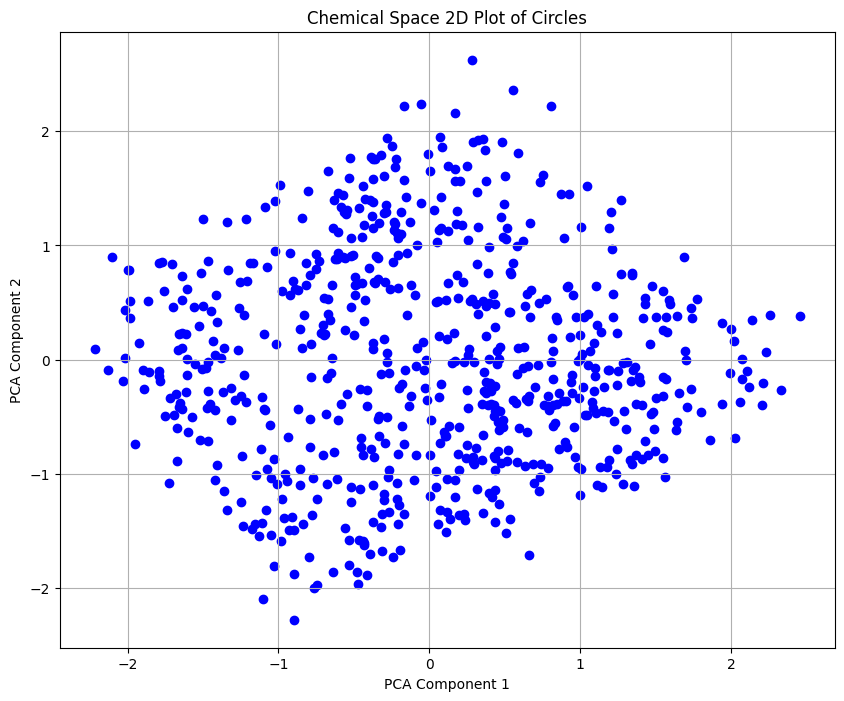

In [ ]:
plot_circles(df50_mol)

Number of circles: 311


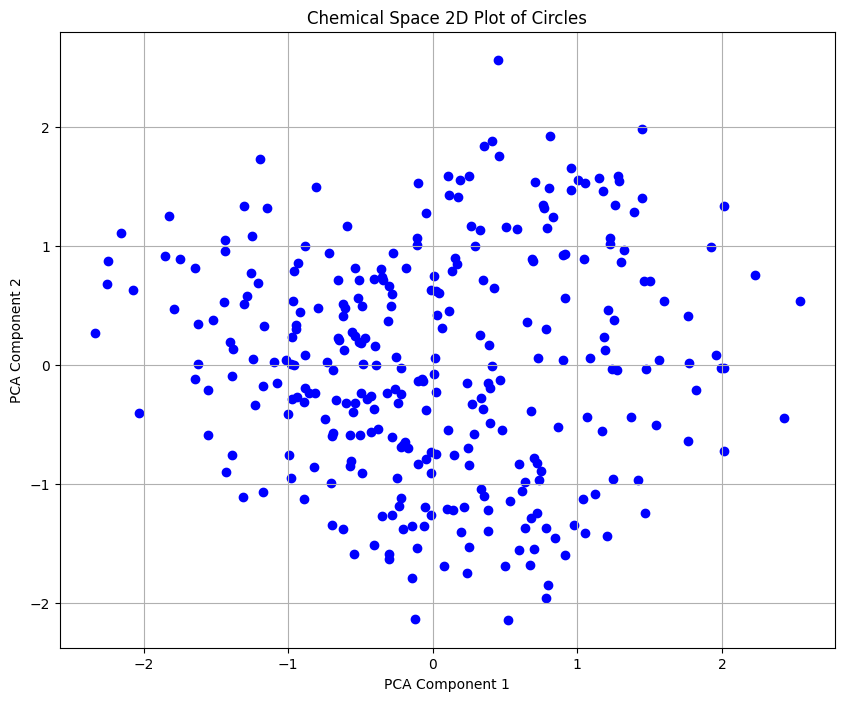

In [ ]:
plot_circles(df_mol)

In [ ]:
import pandas as pd
import numpy as np
import random
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import more_itertools as mit

def plot_circles1(df, n_cluster):
    n_circles, vecs = get_ncircle1(df)  # Properly unpack the returned tuple
    print(f'Number of circles: {n_circles}')

    # Convert fingerprints to numpy array
    vecs_array = np.array([bitvect_to_list(fp) for fp in vecs])

    # Perform K-Means clustering
    kmeans = KMeans(n_clusters=n_cluster, random_state=42)
    cluster_labels = kmeans.fit_predict(vecs_array)

    # Perform PCA to reduce dimensions to 2
    pca = PCA(n_components=2)
    reduced_vecs = pca.fit_transform(vecs_array)

    # Plot the reduced vectors with cluster labels
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(reduced_vecs[:, 0], reduced_vecs[:, 1], c=cluster_labels, cmap='viridis', marker='o')
    plt.title('Chemical Space 2D Plot of Circles with Clusters')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.grid(True)
    plt.legend(*scatter.legend_elements(), title="Clusters")
    plt.show()

In [ ]:
df50_mol1 = df50_mol[['MOL']]
df50_mol1

,MOL
0,<rdkit.Chem.rdchem.Mol object at 0x7b88d095a420>
1,<rdkit.Chem.rdchem.Mol object at 0x7b88d095a490>
2,<rdkit.Chem.rdchem.Mol object at 0x7b88d095a500>
3,<rdkit.Chem.rdchem.Mol object at 0x7b88d095a570>
4,<rdkit.Chem.rdchem.Mol object at 0x7b88d095a5e0>
...,...
49701,<rdkit.Chem.rdchem.Mol object at 0x7b88d03d5380>
49702,<rdkit.Chem.rdchem.Mol object at 0x7b88d03d53f0>
49703,<rdkit.Chem.rdchem.Mol object at 0x7b88d03d5460>
49704,<rdkit.Chem.rdchem.Mol object at 0x7b88d03d54d0>


In [ ]:
df10_mol1 = df10_mol[['MOL']]
df10_mol1

,MOL
0,<rdkit.Chem.rdchem.Mol object at 0x7b88cfdce730>
1,<rdkit.Chem.rdchem.Mol object at 0x7b88cfdce7a0>
2,<rdkit.Chem.rdchem.Mol object at 0x7b88cfdce810>
3,<rdkit.Chem.rdchem.Mol object at 0x7b88cfdce880>
4,<rdkit.Chem.rdchem.Mol object at 0x7b88cfdce8f0>
...,...
10444,<rdkit.Chem.rdchem.Mol object at 0x7b88cfe328f0>
10445,<rdkit.Chem.rdchem.Mol object at 0x7b88cfe32960>
10446,<rdkit.Chem.rdchem.Mol object at 0x7b88cfe329d0>
10447,<rdkit.Chem.rdchem.Mol object at 0x7b88cfe32a40>


In [ ]:
df10_fps

0        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
1        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
2        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
3        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
4        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
                               ...                        
10444    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
10445    [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...
10446    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...
10447    [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
10448    [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
Name: FPS, Length: 10449, dtype: object

In [ ]:
df50_fps

0        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
1        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
2        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
3        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
4        [0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
                               ...                        
49701    [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
49702    [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
49703    [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
49704    [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
49705    [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
Name: FPS, Length: 49706, dtype: object

Number of circles: 306


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


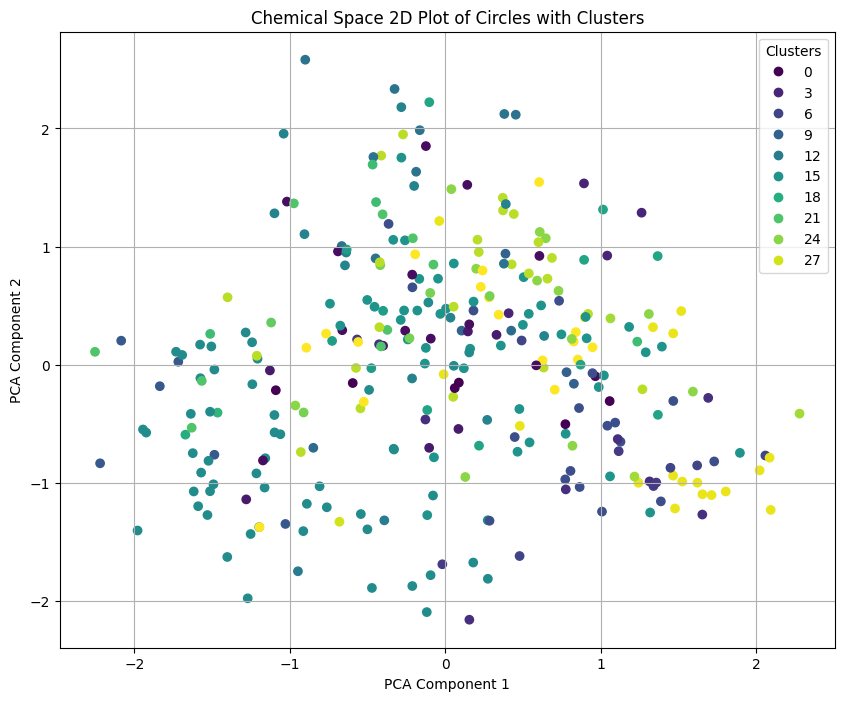

In [ ]:
plot_circles1(df10_mol1, 30)

Number of circles: 686


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


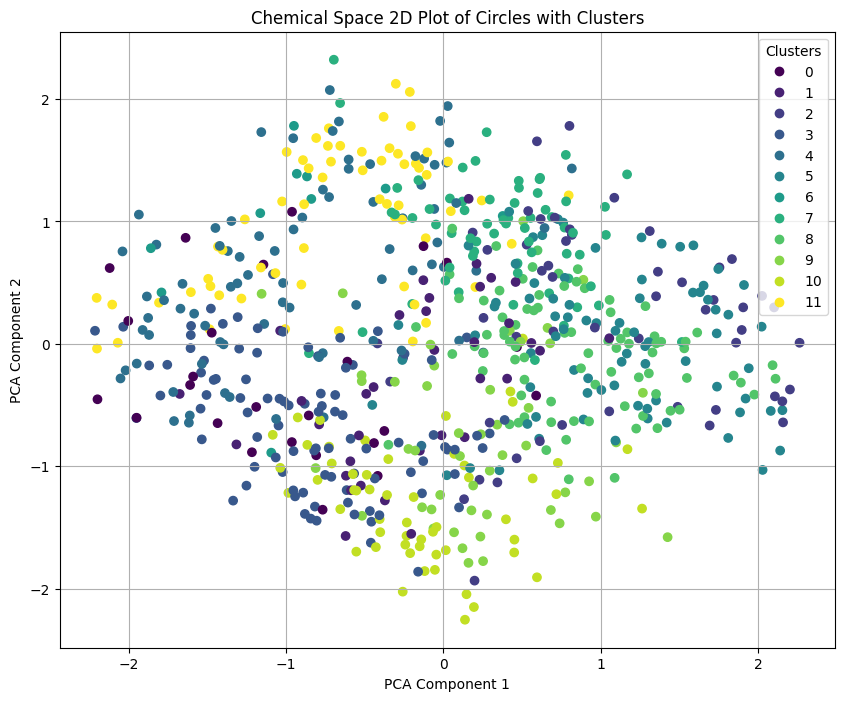

In [ ]:
plot_circles1(df50_mol1, 12)

Number of circles: 667


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


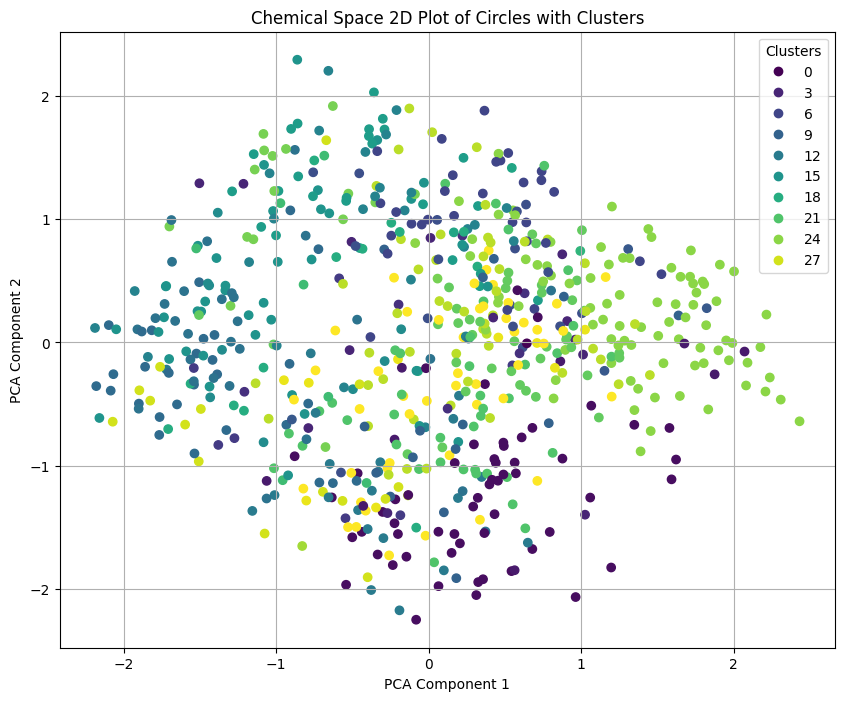

In [ ]:
plot_circles1(df50_mol1, 30)

Number of circles: 315


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


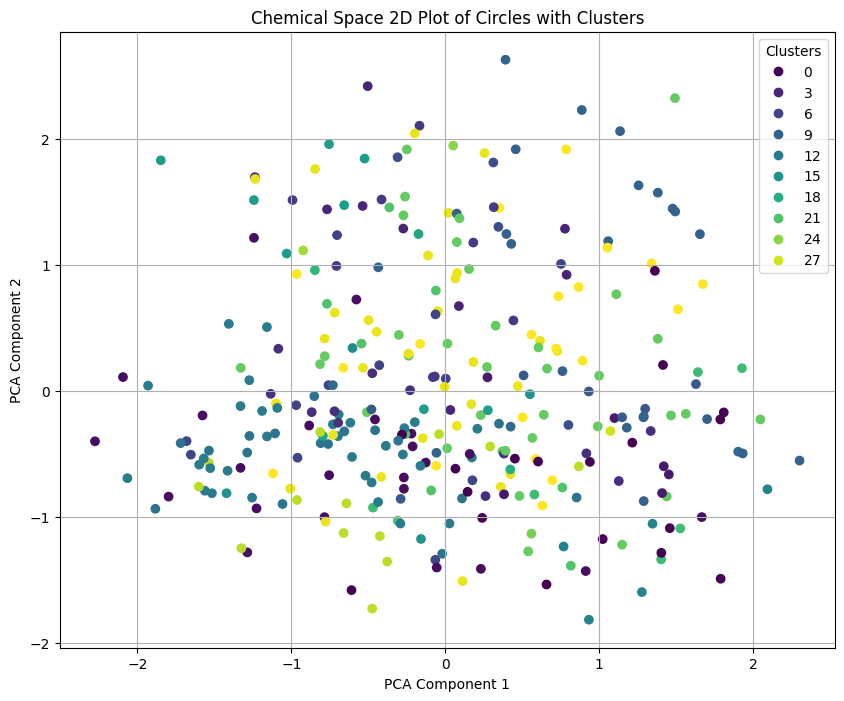

In [ ]:
plot_circles1(df_mol1, 30)

In [ ]:
def elbow_method(data, max_k):
    iters = range(1, max_k+1, 1)
    sse = []

    for k in iters:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(data)
        sse.append(kmeans.inertia_)  # WCSS

    plt.figure(figsize=(10, 8))
    plt.plot(iters, sse, marker='o')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Sum of squared distances (WCSS)')
    plt.title('Elbow Method for Optimal Number of Clusters')
    plt.grid(True)
    plt.show()

In [ ]:
len50, vec50 = get_ncircle1(df50_mol)

In [ ]:
vecs_array50 = np.array([bitvect_to_list(fp) for fp in vec50])

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

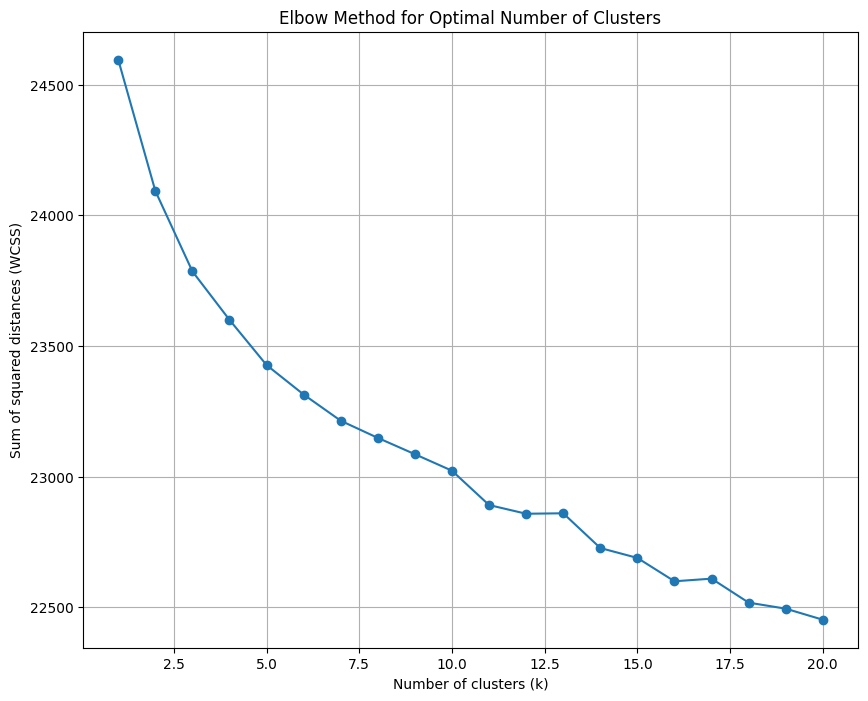

In [ ]:
elbow_method(vecs_array50, 20)

In [ ]:
len, vec = get_ncircle1(df_mol)

In [ ]:
vecs_array = np.array([bitvect_to_list(fp) for fp in vec])

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

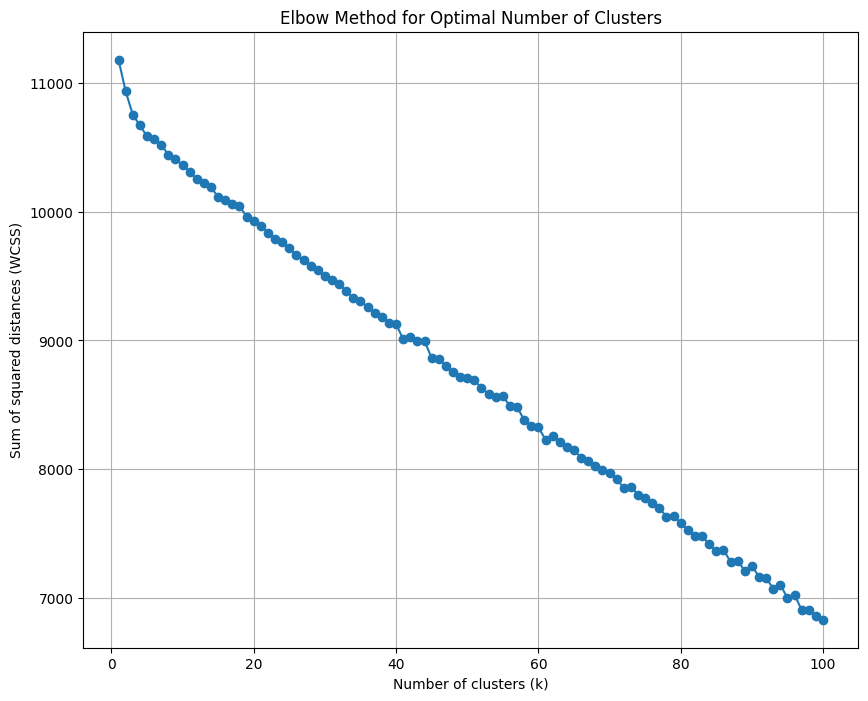

In [ ]:
elbow_method(vecs_array, 100)

## Plot the clusters in the chemical space:

In [ ]:
def get_dissimilar_molecules(df, threshold=0.4):
    ncircles = NCircles(threshold)
    selected_molecules = ncircles.get_circles((list(df['FPS']), similarity_matrix_tanimoto, threshold))
    return selected_molecules

def reduce_dimensionality(fps):
    fps_array = np.array([list(fp) for fp in fps])
    reducer = umap.UMAP(n_components=2, random_state=42)
    reduced_fps = reducer.fit_transform(fps_array)
    return reduced_fps

def plot_chemical_space(reduced_fps, labels):
    plt.figure(figsize=(12, 8))
    scatter = plt.scatter(reduced_fps[:, 0], reduced_fps[:, 1], c=labels, cmap='viridis', alpha=0.7)
    plt.colorbar(scatter)
    plt.title('Chemical Space of Molecules')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.show()

def main(df):
    df = compute_fingerprints(df)
    selected_fps = get_dissimilar_molecules(df)
    reduced_fps = reduce_dimensionality(selected_fps)


    labels = list(range(len(selected_fps)))

    plot_chemical_space(reduced_fps, labels)


csv_file_path = '/content/molpal/data/Enamine10k_smiles.csv.gz'
df = pd.read_csv(csv_file_path)


df['MOL'] = df['smiles'].apply(Chem.MolFromSmiles)

main(df)

NameError: name 'compute_fingerprints' is not defined